In [1]:


import numpy as np 
import pandas as pd 
import cv2

import seaborn as sns
import matplotlib.pyplot as plt


from tqdm import tqdm
from glob import glob
import os


import tensorflow as tf

from tools.unet import Unet,Unet_ResNet,Unet_plusplus
from tools.losses import focal_loss
from MTT.track_manager import TrackManager

from scipy.optimize import curve_fit
from sklearn.cluster import DBSCAN

import skimage
from skimage import morphology
from skimage.filters import rank
from skimage.util import img_as_uint,img_as_ubyte

from nd2reader import ND2Reader
import h5py
import pickle



import warnings
warnings.filterwarnings('ignore')


ModuleNotFoundError: No module named 'MTT'

In [4]:


from tqdm import tqdm
from glob import glob
import os


path_in

In [27]:
te = "G:/instru_projects/TimeLapses/u-wells/IPN/results_240912_timelapse_IPN3mM_3lines_72h_comments"
os.path.split(te)[1][8:]

'240912_timelapse_IPN3mM_3lines_72h_comments'

In [22]:
path_in

'G:/instru_projects/TimeLapses/u-wells/IPN/results_240913_timelapse_IPN3mM_3lines_96h_comments\\{240913}_timelapse_IPN3mM_3lines_96h_comments_{0}_*.mp4'

In [40]:
path = os.path.join('D:/instru_projects/timelapses/', '231109')

vid_name = max( glob(os.path.join(path,'*.nd2')), key =  lambda x: os.stat(x).st_size)

sample_details = {
    "matrix": np.concatenate((np.repeat("IPN_soft", 16), np.repeat("IPN_stiff", 15))),
    "cell": np.array(["MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM"]),
    "ignore": np.array([]), #np.array([1,2,3,4,9,10,11,12,13,14,19,20,21,22,23,24,29,30,31]),
    "stain": "cellTracker_red",
    "dim": "3D",
    "incubation_time": "NA",
    "seeding_density": "NA",
    "passage_number": 0,
    "other": "NA"
}

with ND2Reader(vid_name) as images:
    n_fields = images.metadata['fields_of_view'].stop
    m = images.metadata['pixel_microns']
    n_frames = images.metadata['num_frames']
    z_level = (np.max(images.metadata['z_coordinates'])-np.min(images.metadata['z_coordinates']))
    n_levels = images.metadata['z_levels'].stop
    z_step = z_level/n_levels
    channels = images.metadata['channels']
    n_channels = len(channels)
    vis_level = int(n_levels/2)
    metas = images.metadata

#with ND2Reader()

In [34]:
drive = [os.path.split(path)[0]]
paths = [os.path.split(path)[1]]

#drive_e = ['']
vis = True
save = True
level = 7

v_id = 0
FoV_counter = 0

num_bf = [metas["channels"].index(i) for i in ["BF"]][0]

vid_path = os.path.join(drive[0], './video_{}_{}.avi'.format(level,v_id))
result = cv2.VideoWriter(vid_path, cv2.VideoWriter_fourcc(*'MJPG'), 10, (2304,2304)) 

if vis:
    cv2.namedWindow('vis', cv2.WINDOW_AUTOSIZE)

for path_,drive_ in zip(paths,drive):
    
    path_current = f'{drive_}/{path_}'
    
    vid_name = max( glob(os.path.join(path_current,'*.nd2')),
                key =  lambda x: os.stat(x).st_size)

    counts = {}

    #for i in channels:
    #    if i == "BF":
    #        continue


    with ND2Reader(vid_name) as images:

        #images.iter_axes = 'tc'
        images.iter_axes = 'vtc'
        images.bundle_axes = 'zyx'

        for idx,img in tqdm(enumerate(images),total=n_frames):
            
            c_id = idx%n_channels
            id_name = channels[c_id]

            # skip brightfield
            if (id_name == "BF"):
                print("Skipping BF")
                continue

            frame = img[level]
            frame = (frame/256).astype('uint8')
            frame = np.stack((frame, frame, frame), axis = -1)

            result.write(frame)

            if vis:
                cv2.imshow('vis',cv2.resize(frame, (720,720)))
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            if (FoV_counter == n_frames-1 ) :
                result.release()
                v_id += 1
                FoV_counter = -1
                vid_path = os.path.join(drive[0], './video_{}_{}.avi'.format(level, v_id))
                result = cv2.VideoWriter(vid_path, cv2.VideoWriter_fourcc(*'MJPG'), 10, (2304,2304)) 
                

            FoV_counter += 1
                
if vis:
    cv2.destroyAllWindows()

  0%|          | 0/68 [00:00<?, ?it/s]

  1%|▏         | 1/68 [00:00<00:38,  1.75it/s]

Skipping BF


  4%|▍         | 3/68 [00:03<01:23,  1.29s/it]

Skipping BF


  7%|▋         | 5/68 [00:06<01:42,  1.63s/it]

Skipping BF


 10%|█         | 7/68 [00:09<01:44,  1.71s/it]

Skipping BF


 13%|█▎        | 9/68 [00:13<01:43,  1.76s/it]

Skipping BF


 16%|█▌        | 11/68 [00:16<01:37,  1.72s/it]

Skipping BF


 19%|█▉        | 13/68 [00:19<01:35,  1.74s/it]

Skipping BF


 22%|██▏       | 15/68 [00:22<01:29,  1.69s/it]

Skipping BF


 25%|██▌       | 17/68 [00:25<01:22,  1.62s/it]

Skipping BF


 28%|██▊       | 19/68 [00:28<01:20,  1.64s/it]

Skipping BF


 31%|███       | 21/68 [00:31<01:17,  1.65s/it]

Skipping BF


 34%|███▍      | 23/68 [00:33<01:12,  1.61s/it]

Skipping BF


 37%|███▋      | 25/68 [00:37<01:11,  1.65s/it]

Skipping BF


 40%|███▉      | 27/68 [00:40<01:09,  1.69s/it]

Skipping BF


 43%|████▎     | 29/68 [00:43<01:05,  1.68s/it]

Skipping BF


 46%|████▌     | 31/68 [00:46<01:01,  1.66s/it]

Skipping BF


 49%|████▊     | 33/68 [00:49<00:59,  1.69s/it]

Skipping BF


 51%|█████▏    | 35/68 [00:52<00:54,  1.66s/it]

Skipping BF


 54%|█████▍    | 37/68 [00:55<00:49,  1.61s/it]

Skipping BF


 57%|█████▋    | 39/68 [00:57<00:45,  1.57s/it]

Skipping BF


 60%|██████    | 41/68 [01:00<00:43,  1.61s/it]

Skipping BF


 63%|██████▎   | 43/68 [01:03<00:41,  1.66s/it]

Skipping BF


 66%|██████▌   | 45/68 [01:06<00:37,  1.62s/it]

Skipping BF


 69%|██████▉   | 47/68 [01:09<00:33,  1.59s/it]

Skipping BF


 72%|███████▏  | 49/68 [01:12<00:30,  1.61s/it]

Skipping BF


 75%|███████▌  | 51/68 [01:15<00:27,  1.61s/it]

Skipping BF


 78%|███████▊  | 53/68 [01:18<00:24,  1.66s/it]

Skipping BF


 81%|████████  | 55/68 [01:21<00:21,  1.67s/it]

Skipping BF


 84%|████████▍ | 57/68 [01:24<00:19,  1.73s/it]

Skipping BF


 87%|████████▋ | 59/68 [01:27<00:15,  1.68s/it]

Skipping BF


 90%|████████▉ | 61/68 [01:30<00:11,  1.68s/it]

Skipping BF


 93%|█████████▎| 63/68 [01:33<00:08,  1.66s/it]

Skipping BF


 96%|█████████▌| 65/68 [01:36<00:04,  1.66s/it]

Skipping BF


 99%|█████████▊| 67/68 [01:39<00:01,  1.67s/it]

Skipping BF


69it [01:42,  1.70s/it]                        

Skipping BF


71it [01:45,  1.75s/it]

Skipping BF


73it [01:48,  1.67s/it]

Skipping BF


75it [01:51,  1.66s/it]

Skipping BF


77it [01:54,  1.63s/it]

Skipping BF


79it [01:57,  1.64s/it]

Skipping BF


81it [02:00,  1.62s/it]

Skipping BF


83it [02:03,  1.69s/it]

Skipping BF


85it [02:06,  1.73s/it]

Skipping BF


87it [02:10,  1.74s/it]

Skipping BF


89it [02:13,  1.73s/it]

Skipping BF


91it [02:16,  1.75s/it]

Skipping BF


93it [02:19,  1.72s/it]

Skipping BF


95it [02:22,  1.67s/it]

Skipping BF


97it [02:25,  1.63s/it]

Skipping BF


99it [02:28,  1.67s/it]

Skipping BF


101it [02:31,  1.64s/it]

Skipping BF


103it [02:34,  1.64s/it]

Skipping BF


105it [02:37,  1.71s/it]

Skipping BF


107it [02:40,  1.67s/it]

Skipping BF


109it [02:43,  1.64s/it]

Skipping BF


111it [02:46,  1.65s/it]

Skipping BF


113it [02:49,  1.67s/it]

Skipping BF


115it [02:52,  1.66s/it]

Skipping BF


117it [02:55,  1.64s/it]

Skipping BF


119it [02:58,  1.63s/it]

Skipping BF


121it [03:00,  1.63s/it]

Skipping BF


123it [03:03,  1.65s/it]

Skipping BF


125it [03:07,  1.70s/it]

Skipping BF


127it [03:10,  1.64s/it]

Skipping BF


129it [03:13,  1.67s/it]

Skipping BF


131it [03:16,  1.67s/it]

Skipping BF


133it [03:19,  1.69s/it]

Skipping BF


135it [03:22,  1.71s/it]

Skipping BF


137it [03:25,  1.66s/it]

Skipping BF


139it [03:28,  1.71s/it]

Skipping BF


141it [03:31,  1.83s/it]

Skipping BF


143it [03:35,  1.82s/it]

Skipping BF


145it [03:38,  1.72s/it]

Skipping BF


147it [03:41,  1.67s/it]

Skipping BF


149it [03:44,  1.70s/it]

Skipping BF


151it [03:47,  1.68s/it]

Skipping BF


153it [03:50,  1.65s/it]

Skipping BF


155it [03:53,  1.61s/it]

Skipping BF


157it [03:55,  1.56s/it]

Skipping BF


159it [03:58,  1.55s/it]

Skipping BF


161it [04:01,  1.59s/it]

Skipping BF


163it [04:04,  1.60s/it]

Skipping BF


165it [04:07,  1.56s/it]

Skipping BF


167it [04:10,  1.56s/it]

Skipping BF


169it [04:12,  1.56s/it]

Skipping BF


171it [04:15,  1.55s/it]

Skipping BF


173it [04:18,  1.55s/it]

Skipping BF


175it [04:21,  1.59s/it]

Skipping BF


177it [04:24,  1.59s/it]

Skipping BF


179it [04:27,  1.59s/it]

Skipping BF


181it [04:30,  1.60s/it]

Skipping BF


183it [04:32,  1.57s/it]

Skipping BF


185it [04:36,  1.66s/it]

Skipping BF


187it [04:38,  1.62s/it]

Skipping BF


189it [04:41,  1.60s/it]

Skipping BF


191it [04:45,  1.80s/it]

Skipping BF


193it [04:48,  1.68s/it]

Skipping BF


195it [04:51,  1.64s/it]

Skipping BF


197it [04:54,  1.63s/it]

Skipping BF


199it [04:57,  1.62s/it]

Skipping BF


201it [05:00,  1.60s/it]

Skipping BF


203it [05:03,  1.66s/it]

Skipping BF


205it [05:06,  1.63s/it]

Skipping BF


207it [05:08,  1.63s/it]

Skipping BF


209it [05:12,  1.67s/it]

Skipping BF


211it [05:14,  1.58s/it]

Skipping BF


213it [05:17,  1.65s/it]

Skipping BF


215it [05:21,  1.72s/it]

Skipping BF


217it [05:24,  1.71s/it]

Skipping BF


219it [05:27,  1.72s/it]

Skipping BF


221it [05:30,  1.69s/it]

Skipping BF


223it [05:33,  1.69s/it]

Skipping BF


225it [05:36,  1.67s/it]

Skipping BF


227it [05:39,  1.71s/it]

Skipping BF


229it [05:42,  1.65s/it]

Skipping BF


231it [05:45,  1.62s/it]

Skipping BF


233it [05:48,  1.60s/it]

Skipping BF


235it [05:50,  1.60s/it]

Skipping BF


237it [05:53,  1.60s/it]

Skipping BF


239it [05:56,  1.58s/it]

Skipping BF


241it [05:59,  1.58s/it]

Skipping BF


243it [06:02,  1.58s/it]

Skipping BF


245it [06:05,  1.65s/it]

Skipping BF


247it [06:08,  1.60s/it]

Skipping BF


249it [06:11,  1.57s/it]

Skipping BF


251it [06:14,  1.64s/it]

Skipping BF


253it [06:17,  1.63s/it]

Skipping BF


255it [06:20,  1.64s/it]

Skipping BF


257it [06:23,  1.61s/it]

Skipping BF


259it [06:25,  1.57s/it]

Skipping BF


261it [06:28,  1.64s/it]

Skipping BF


263it [06:31,  1.60s/it]

Skipping BF


265it [06:34,  1.61s/it]

Skipping BF


267it [06:37,  1.60s/it]

Skipping BF


269it [06:40,  1.64s/it]

Skipping BF


271it [06:43,  1.64s/it]

Skipping BF


273it [06:46,  1.64s/it]

Skipping BF


275it [06:49,  1.66s/it]

Skipping BF


277it [06:52,  1.68s/it]

Skipping BF


279it [06:55,  1.73s/it]

Skipping BF


281it [06:58,  1.73s/it]

Skipping BF


283it [07:02,  1.73s/it]

Skipping BF


285it [07:05,  1.75s/it]

Skipping BF


287it [07:08,  1.74s/it]

Skipping BF


289it [07:11,  1.75s/it]

Skipping BF


291it [07:14,  1.77s/it]

Skipping BF


293it [07:18,  1.93s/it]

Skipping BF


295it [07:22,  1.91s/it]

Skipping BF


297it [07:25,  1.72s/it]

Skipping BF


299it [07:28,  1.68s/it]

Skipping BF


301it [07:30,  1.62s/it]

Skipping BF


303it [07:34,  1.70s/it]

Skipping BF


305it [07:37,  1.65s/it]

Skipping BF


307it [07:40,  1.64s/it]

Skipping BF


309it [07:42,  1.61s/it]

Skipping BF


311it [07:45,  1.57s/it]

Skipping BF


313it [07:48,  1.54s/it]

Skipping BF


315it [07:51,  1.59s/it]

Skipping BF


317it [07:54,  1.59s/it]

Skipping BF


319it [07:57,  1.59s/it]

Skipping BF


321it [07:59,  1.57s/it]

Skipping BF


323it [08:02,  1.61s/it]

Skipping BF


325it [08:05,  1.62s/it]

Skipping BF


327it [08:08,  1.62s/it]

Skipping BF


329it [08:11,  1.60s/it]

Skipping BF


331it [08:14,  1.60s/it]

Skipping BF


333it [08:17,  1.63s/it]

Skipping BF


335it [08:20,  1.63s/it]

Skipping BF


337it [08:23,  1.61s/it]

Skipping BF


339it [08:26,  1.62s/it]

Skipping BF


341it [08:29,  1.62s/it]

Skipping BF


343it [08:32,  1.60s/it]

Skipping BF


345it [08:34,  1.60s/it]

Skipping BF


347it [08:37,  1.61s/it]

Skipping BF


349it [08:40,  1.58s/it]

Skipping BF


351it [08:43,  1.57s/it]

Skipping BF


353it [08:46,  1.54s/it]

Skipping BF


355it [08:49,  1.58s/it]

Skipping BF


357it [08:52,  1.61s/it]

Skipping BF


359it [08:55,  1.62s/it]

Skipping BF


361it [08:58,  1.69s/it]

Skipping BF


363it [09:01,  1.67s/it]

Skipping BF


365it [09:04,  1.62s/it]

Skipping BF


367it [09:06,  1.60s/it]

Skipping BF


369it [09:09,  1.57s/it]

Skipping BF


371it [09:12,  1.58s/it]

Skipping BF


373it [09:15,  1.59s/it]

Skipping BF


375it [09:18,  1.59s/it]

Skipping BF


377it [09:21,  1.68s/it]

Skipping BF


379it [09:24,  1.72s/it]

Skipping BF


381it [09:28,  1.71s/it]

Skipping BF


383it [09:31,  1.71s/it]

Skipping BF


385it [09:34,  1.68s/it]

Skipping BF


387it [09:37,  1.66s/it]

Skipping BF


389it [09:40,  1.69s/it]

Skipping BF


391it [09:43,  1.67s/it]

Skipping BF


393it [09:46,  1.65s/it]

Skipping BF


395it [09:49,  1.58s/it]

Skipping BF


397it [09:51,  1.54s/it]

Skipping BF


399it [09:54,  1.55s/it]

Skipping BF


401it [09:57,  1.57s/it]

Skipping BF


403it [10:00,  1.60s/it]

Skipping BF


405it [10:03,  1.63s/it]

Skipping BF


407it [10:06,  1.62s/it]

Skipping BF


409it [10:09,  1.62s/it]

Skipping BF


411it [10:11,  1.55s/it]

Skipping BF


413it [10:15,  1.62s/it]

Skipping BF


415it [10:18,  1.65s/it]

Skipping BF


417it [10:21,  1.69s/it]

Skipping BF


419it [10:24,  1.68s/it]

Skipping BF


421it [10:27,  1.67s/it]

Skipping BF


423it [10:29,  1.59s/it]

Skipping BF


425it [10:32,  1.60s/it]

Skipping BF


427it [10:35,  1.58s/it]

Skipping BF


429it [10:38,  1.59s/it]

Skipping BF


431it [10:41,  1.60s/it]

Skipping BF


433it [10:44,  1.61s/it]

Skipping BF


435it [10:47,  1.56s/it]

Skipping BF


437it [10:49,  1.52s/it]

Skipping BF


439it [10:52,  1.52s/it]

Skipping BF


441it [10:55,  1.52s/it]

Skipping BF


443it [10:58,  1.54s/it]

Skipping BF


445it [11:01,  1.55s/it]

Skipping BF


447it [11:04,  1.58s/it]

Skipping BF


449it [11:06,  1.56s/it]

Skipping BF


451it [11:09,  1.56s/it]

Skipping BF


453it [11:12,  1.53s/it]

Skipping BF


455it [11:15,  1.52s/it]

Skipping BF


457it [11:17,  1.53s/it]

Skipping BF


459it [11:20,  1.54s/it]

Skipping BF


461it [11:23,  1.55s/it]

Skipping BF


463it [11:26,  1.56s/it]

Skipping BF


465it [11:29,  1.59s/it]

Skipping BF


467it [11:32,  1.60s/it]

Skipping BF


469it [11:35,  1.61s/it]

Skipping BF


471it [11:38,  1.58s/it]

Skipping BF


473it [11:41,  1.61s/it]

Skipping BF


475it [11:44,  1.64s/it]

Skipping BF


477it [11:46,  1.64s/it]

Skipping BF


479it [11:49,  1.62s/it]

Skipping BF


481it [11:52,  1.61s/it]

Skipping BF


483it [11:55,  1.59s/it]

Skipping BF


485it [11:58,  1.57s/it]

Skipping BF


487it [12:01,  1.56s/it]

Skipping BF


489it [12:04,  1.55s/it]

Skipping BF


491it [12:07,  1.61s/it]

Skipping BF


493it [12:11,  1.87s/it]

Skipping BF


495it [12:15,  2.03s/it]

Skipping BF


497it [12:19,  2.12s/it]

Skipping BF


499it [12:23,  2.14s/it]

Skipping BF


501it [12:27,  2.17s/it]

Skipping BF


503it [12:31,  2.12s/it]

Skipping BF


505it [12:34,  2.07s/it]

Skipping BF


507it [12:38,  2.07s/it]

Skipping BF


509it [12:42,  2.05s/it]

Skipping BF


511it [12:46,  2.03s/it]

Skipping BF


513it [12:50,  2.04s/it]

Skipping BF


515it [12:54,  2.04s/it]

Skipping BF


517it [12:57,  2.05s/it]

Skipping BF


519it [13:01,  2.04s/it]

Skipping BF


521it [13:05,  2.05s/it]

Skipping BF


523it [13:09,  2.05s/it]

Skipping BF


525it [13:13,  2.08s/it]

Skipping BF


527it [13:17,  2.07s/it]

Skipping BF


529it [13:21,  2.09s/it]

Skipping BF


531it [13:24,  2.08s/it]

Skipping BF


533it [13:28,  2.06s/it]

Skipping BF


535it [13:33,  2.20s/it]

Skipping BF


537it [13:37,  2.29s/it]

Skipping BF


539it [13:41,  2.22s/it]

Skipping BF


541it [13:45,  2.15s/it]

Skipping BF


543it [13:49,  2.13s/it]

Skipping BF


545it [13:53,  2.08s/it]

Skipping BF


547it [13:57,  2.07s/it]

Skipping BF


549it [14:00,  2.06s/it]

Skipping BF


551it [14:04,  2.09s/it]

Skipping BF


553it [14:09,  2.18s/it]

Skipping BF


555it [14:13,  2.36s/it]

Skipping BF


557it [14:18,  2.46s/it]

Skipping BF


559it [14:23,  2.46s/it]

Skipping BF


561it [14:27,  2.44s/it]

Skipping BF


563it [14:32,  2.48s/it]

Skipping BF


565it [14:36,  2.48s/it]

Skipping BF


567it [14:41,  2.48s/it]

Skipping BF


569it [14:46,  2.54s/it]

Skipping BF


571it [14:50,  2.50s/it]

Skipping BF


573it [14:55,  2.44s/it]

Skipping BF


575it [14:59,  2.46s/it]

Skipping BF


577it [15:04,  2.45s/it]

Skipping BF


579it [15:08,  2.53s/it]

Skipping BF


581it [15:12,  2.29s/it]

Skipping BF


583it [15:16,  2.12s/it]

Skipping BF


585it [15:20,  2.10s/it]

Skipping BF


587it [15:24,  2.07s/it]

Skipping BF


589it [15:27,  2.03s/it]

Skipping BF


591it [15:31,  2.04s/it]

Skipping BF


593it [15:35,  2.03s/it]

Skipping BF


595it [15:39,  2.07s/it]

Skipping BF


597it [15:43,  2.05s/it]

Skipping BF


599it [15:47,  2.05s/it]

Skipping BF


601it [15:50,  2.06s/it]

Skipping BF


603it [15:54,  2.07s/it]

Skipping BF


605it [15:58,  2.08s/it]

Skipping BF


607it [16:02,  2.02s/it]

Skipping BF


609it [16:06,  1.99s/it]

Skipping BF


611it [16:09,  2.04s/it]

Skipping BF


613it [16:13,  2.03s/it]

Skipping BF


615it [16:17,  2.05s/it]

Skipping BF


617it [16:21,  2.07s/it]

Skipping BF


619it [16:25,  2.12s/it]

Skipping BF


621it [16:29,  2.12s/it]

Skipping BF


623it [16:33,  2.04s/it]

Skipping BF


625it [16:37,  2.02s/it]

Skipping BF


627it [16:40,  2.06s/it]

Skipping BF


629it [16:44,  2.11s/it]

Skipping BF


631it [16:48,  2.13s/it]

Skipping BF


633it [16:53,  2.15s/it]

Skipping BF


635it [16:56,  2.09s/it]

Skipping BF


637it [17:00,  2.13s/it]

Skipping BF


639it [17:04,  2.07s/it]

Skipping BF


641it [17:08,  2.07s/it]

Skipping BF


643it [17:12,  2.18s/it]

Skipping BF


645it [17:17,  2.31s/it]

Skipping BF


647it [17:21,  2.16s/it]

Skipping BF


649it [17:24,  2.11s/it]

Skipping BF


651it [17:28,  2.08s/it]

Skipping BF


653it [17:32,  2.09s/it]

Skipping BF


655it [17:36,  2.21s/it]

Skipping BF


657it [17:40,  2.14s/it]

Skipping BF


659it [17:44,  2.07s/it]

Skipping BF


661it [17:48,  2.08s/it]

Skipping BF


663it [17:52,  2.09s/it]

Skipping BF


665it [17:56,  2.07s/it]

Skipping BF


667it [18:00,  2.06s/it]

Skipping BF


669it [18:04,  2.10s/it]

Skipping BF


671it [18:07,  2.08s/it]

Skipping BF


673it [18:11,  2.11s/it]

Skipping BF


675it [18:15,  2.12s/it]

Skipping BF


677it [18:19,  2.13s/it]

Skipping BF


679it [18:23,  2.10s/it]

Skipping BF


681it [18:27,  2.07s/it]

Skipping BF


683it [18:31,  2.09s/it]

Skipping BF


685it [18:35,  2.15s/it]

Skipping BF


687it [18:39,  2.13s/it]

Skipping BF


689it [18:43,  2.17s/it]

Skipping BF


691it [18:47,  2.18s/it]

Skipping BF


693it [18:51,  2.17s/it]

Skipping BF


695it [18:55,  2.11s/it]

Skipping BF


697it [18:59,  2.10s/it]

Skipping BF


699it [19:03,  2.11s/it]

Skipping BF


701it [19:07,  2.09s/it]

Skipping BF


703it [19:10,  2.00s/it]

Skipping BF


705it [19:14,  2.04s/it]

Skipping BF


707it [19:18,  2.05s/it]

Skipping BF


709it [19:22,  2.07s/it]

Skipping BF


711it [19:26,  2.10s/it]

Skipping BF


713it [19:30,  2.09s/it]

Skipping BF


715it [19:34,  2.09s/it]

Skipping BF


717it [19:38,  2.09s/it]

Skipping BF


719it [19:42,  2.07s/it]

Skipping BF


721it [19:45,  2.05s/it]

Skipping BF


723it [19:49,  2.06s/it]

Skipping BF


725it [19:53,  2.08s/it]

Skipping BF


727it [19:57,  2.12s/it]

Skipping BF


729it [20:01,  2.10s/it]

Skipping BF


731it [20:05,  2.11s/it]

Skipping BF


733it [20:09,  2.12s/it]

Skipping BF


735it [20:13,  2.12s/it]

Skipping BF


737it [20:17,  2.06s/it]

Skipping BF


739it [20:21,  2.09s/it]

Skipping BF


741it [20:24,  2.09s/it]

Skipping BF


743it [20:28,  2.09s/it]

Skipping BF


745it [20:32,  2.10s/it]

Skipping BF


747it [20:36,  2.12s/it]

Skipping BF


749it [20:40,  2.14s/it]

Skipping BF


751it [20:44,  2.10s/it]

Skipping BF


753it [20:48,  2.10s/it]

Skipping BF


755it [20:52,  2.07s/it]

Skipping BF


757it [20:56,  2.08s/it]

Skipping BF


759it [21:00,  2.10s/it]

Skipping BF


761it [21:04,  2.09s/it]

Skipping BF


763it [21:08,  2.14s/it]

Skipping BF


765it [21:12,  2.13s/it]

Skipping BF


767it [21:16,  2.17s/it]

Skipping BF


769it [21:20,  2.14s/it]

Skipping BF


771it [21:24,  2.12s/it]

Skipping BF


773it [21:27,  2.06s/it]

Skipping BF


775it [21:31,  2.08s/it]

Skipping BF


777it [21:35,  2.09s/it]

Skipping BF


779it [21:39,  2.10s/it]

Skipping BF


781it [21:43,  2.12s/it]

Skipping BF


783it [21:47,  2.04s/it]

Skipping BF


785it [21:51,  2.05s/it]

Skipping BF


787it [21:54,  2.04s/it]

Skipping BF


789it [21:58,  1.97s/it]

Skipping BF


791it [22:02,  2.02s/it]

Skipping BF


793it [22:06,  2.06s/it]

Skipping BF


795it [22:10,  2.10s/it]

Skipping BF


797it [22:14,  2.08s/it]

Skipping BF


799it [22:17,  2.09s/it]

Skipping BF


801it [22:22,  2.14s/it]

Skipping BF


803it [22:25,  2.08s/it]

Skipping BF


805it [22:29,  2.08s/it]

Skipping BF


807it [22:33,  2.08s/it]

Skipping BF


809it [22:37,  2.08s/it]

Skipping BF


811it [22:41,  2.09s/it]

Skipping BF


813it [22:45,  2.08s/it]

Skipping BF


815it [22:49,  2.08s/it]

Skipping BF


817it [22:53,  2.07s/it]

Skipping BF


819it [22:56,  2.06s/it]

Skipping BF


821it [23:00,  2.11s/it]

Skipping BF


823it [23:04,  2.15s/it]

Skipping BF


825it [23:08,  2.15s/it]

Skipping BF


827it [23:12,  2.08s/it]

Skipping BF


829it [23:16,  2.11s/it]

Skipping BF


831it [23:20,  2.11s/it]

Skipping BF


833it [23:24,  2.06s/it]

Skipping BF


835it [23:28,  2.04s/it]

Skipping BF


837it [23:31,  2.04s/it]

Skipping BF


839it [23:35,  2.05s/it]

Skipping BF


841it [23:39,  2.07s/it]

Skipping BF


843it [23:43,  2.07s/it]

Skipping BF


845it [23:47,  2.08s/it]

Skipping BF


847it [23:51,  2.07s/it]

Skipping BF


849it [23:55,  2.10s/it]

Skipping BF


851it [23:59,  2.07s/it]

Skipping BF


853it [24:02,  2.07s/it]

Skipping BF


855it [24:06,  2.09s/it]

Skipping BF


857it [24:10,  2.06s/it]

Skipping BF


859it [24:14,  2.00s/it]

Skipping BF


861it [24:18,  2.02s/it]

Skipping BF


863it [24:21,  2.05s/it]

Skipping BF


865it [24:25,  2.03s/it]

Skipping BF


867it [24:29,  2.06s/it]

Skipping BF


869it [24:33,  2.06s/it]

Skipping BF


871it [24:37,  2.06s/it]

Skipping BF


873it [24:41,  2.09s/it]

Skipping BF


875it [24:44,  2.06s/it]

Skipping BF


877it [24:48,  2.06s/it]

Skipping BF


879it [24:52,  2.08s/it]

Skipping BF


881it [24:56,  2.08s/it]

Skipping BF


883it [25:00,  2.06s/it]

Skipping BF


885it [25:04,  2.08s/it]

Skipping BF


887it [25:08,  2.10s/it]

Skipping BF


889it [25:11,  2.06s/it]

Skipping BF


891it [25:15,  2.05s/it]

Skipping BF


893it [25:19,  2.04s/it]

Skipping BF


895it [25:23,  2.04s/it]

Skipping BF


897it [25:27,  2.04s/it]

Skipping BF


899it [25:31,  2.09s/it]

Skipping BF


901it [25:35,  2.14s/it]

Skipping BF


903it [25:39,  2.15s/it]

Skipping BF


905it [25:43,  2.15s/it]

Skipping BF


907it [25:47,  2.16s/it]

Skipping BF


909it [25:51,  2.11s/it]

Skipping BF


911it [25:54,  2.09s/it]

Skipping BF


913it [25:58,  2.08s/it]

Skipping BF


915it [26:02,  2.06s/it]

Skipping BF


917it [26:06,  2.08s/it]

Skipping BF


919it [26:10,  2.08s/it]

Skipping BF


921it [26:14,  2.07s/it]

Skipping BF


923it [26:18,  2.07s/it]

Skipping BF


925it [26:22,  2.09s/it]

Skipping BF


927it [26:26,  2.09s/it]

Skipping BF


929it [26:29,  2.11s/it]

Skipping BF


931it [26:33,  2.09s/it]

Skipping BF


933it [26:37,  2.09s/it]

Skipping BF


935it [26:41,  2.08s/it]

Skipping BF


937it [26:45,  2.05s/it]

Skipping BF


939it [26:49,  2.06s/it]

Skipping BF


941it [26:53,  2.06s/it]

Skipping BF


943it [26:56,  1.99s/it]

Skipping BF


945it [27:00,  1.99s/it]

Skipping BF


947it [27:04,  2.05s/it]

Skipping BF


949it [27:08,  2.10s/it]

Skipping BF


951it [27:12,  2.11s/it]

Skipping BF


953it [27:16,  2.12s/it]

Skipping BF


955it [27:20,  2.08s/it]

Skipping BF


957it [27:24,  2.12s/it]

Skipping BF


959it [27:28,  2.13s/it]

Skipping BF


961it [27:32,  2.14s/it]

Skipping BF


963it [27:36,  2.14s/it]

Skipping BF


965it [27:40,  2.14s/it]

Skipping BF


967it [27:43,  2.06s/it]

Skipping BF


968it [27:45,  1.72s/it]


OSError: [Errno 22] Invalid argument

### Download detection model

In [8]:
model = Unet_plusplus(1,512,loss='focal')

custom_objects = {"loss": focal_loss}
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model('./arttu_model5')

In [39]:
drive = ['D:/instru_projects/timelapses/']
#drive = ['E:/']
#paths = ['231110']
paths = ['231109']

sample_details = {
    "matrix": np.concatenate((np.repeat("IPN_soft", 16), np.repeat("IPN_stiff", 15))),
    "cell": np.array(["MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10A", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10AT", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM", "MCF10A.DCIS.COM"]),
    "ignore": np.array([]), #np.array([1,2,3,4,9,10,11,12,13,14,19,20,21,22,23,24,29,30,31]),
    "stain": "cellTracker_red",
    "dim": "3D",
    "incubation_time": "NA",
    "seeding_density": "NA",
    "passage_number": 0,
    "other": "NA"
}


def read_meta(path):
    vid_name = max( glob(os.path.join(path,'*.nd2')), key =  lambda x: os.stat(x).st_size)

    with ND2Reader(vid_name) as images:
        metas = images.metadata

    return metas


for path_,drive_ in zip(paths,drive):
    
    path = f'{drive_}{path_}'
    path_parts = os.path.split(path)

    metas = read_meta(path)
    num_bf = [metas["channels"].index(i) for i in ["BF"]][0]

    vid_name = max( glob(os.path.join(path,'*.nd2')),
                key =  lambda x: os.stat(x).st_size)
    
    with ND2Reader(vid_name) as images:
        n_fields = images.metadata['fields_of_view'].stop
        m = images.metadata['pixel_microns']
        n_frames = images.metadata['num_frames']
        z_level = (np.max(images.metadata['z_coordinates'])-np.min(images.metadata['z_coordinates']))
        n_levels = images.metadata['z_levels'].stop
        z_step = z_level/n_levels
        channels = images.metadata['channels']
        n_channels = len(channels)
        vis_level = int(n_levels/2)
        metas = images.metadata
        height = metas["height"]
        width = metas["width"]

In [10]:
def read_meta(path):
    vid_name = max( glob(os.path.join(path,'*.nd2')), key =  lambda x: os.stat(x).st_size)

    with ND2Reader(vid_name) as images:
        metas = images.metadata

    return metas

wanted_channel = "Red"

vis = True
save = True
ball = morphology.disk(15)
conv_coef = 70

DBScan_distance = 10
DBScan_minSample = 3

if vis:
    cv2.namedWindow('vis', cv2.WINDOW_AUTOSIZE)
   
    size = (512, 512) 

for path_,drive_ in zip(paths,drive):
    
    path = f'{drive_}{path_}'
    path_parts = os.path.split(path)

    metas = read_meta(path)
    num_bf = [metas["channels"].index(i) for i in ["BF"]][0]

    vid_name = max( glob(os.path.join(path,'*.nd2')),
                key =  lambda x: os.stat(x).st_size)
    
    with ND2Reader(vid_name) as images:
        n_fields = images.metadata['fields_of_view'].stop
        m = images.metadata['pixel_microns']
        n_frames = images.metadata['num_frames']
        z_level = (np.max(images.metadata['z_coordinates'])-np.min(images.metadata['z_coordinates']))
        n_levels = images.metadata['z_levels'].stop
        z_step = z_level/n_levels
        channels = images.metadata['channels']
        n_channels = len(channels)
        vis_level = int(n_levels/2)
        metas = images.metadata
        height = metas["height"]
        width = metas["width"]

    counts = {}

    for i in channels:
        if (i != wanted_channel):
            continue
        else:
            counts[i] = {}
            counts[i]['dets'] = np.zeros((n_fields,n_frames))
            counts[i]['coords'] = {}
            for j in range(n_fields):
                counts[i]['coords'][j] = []

    skip = False
    t_id = 0
    v_id = 0

    with ND2Reader(vid_name) as images:

        #images.iter_axes = 'tc'
        if n_fields == 1:
            images.iter_axes = 'tc'
        else:
            images.iter_axes = 'vtc'

        images.bundle_axes = 'zyx'
                
        
        FoV_counter = 0
        for idx,img in tqdm(enumerate(images),total=int((n_channels*n_fields*n_frames))):

            if (vis == True) & (FoV_counter == 0):
                vid_path = os.path.join(drive[index], '{}/video_{}.avi'.format(paths[index],v_id))
                result = cv2.VideoWriter(vid_path,  
                                cv2.VideoWriter_fourcc(*'MJPG'), 
                            10, size) 
        
            c_id = idx%n_channels
            id_name = channels[c_id]

            # skip brightfield
            
            if (id_name != wanted_channel):
                print("Skipping BF")
                if idx != 0:
                    t_id += 1

                continue

            z_predictions = []
            normalized = np.zeros((n_levels,512,512))

            for i in images.metadata['z_levels']:

                final = cv2.normalize(img[i,...],  None, 0, 255, cv2.NORM_MINMAX)
                final = 255-cv2.resize(final,(512,512))
                normalized[i] = final

            if n_levels>11:
                res_1 = model.predict(np.tile(normalized[:7,...,np.newaxis],(1,1,1,3))/255.)
                res_2 = model.predict(np.tile(normalized[7:,...,np.newaxis],(1,1,1,3))/255.)
                res = np.vstack([res_1,res_2])
            else:
                res = model.predict(np.tile(normalized[...,np.newaxis],(1,1,1,3))/255.)

            convs = np.zeros_like(res[...,0],dtype=np.uint8)
            convs_ = np.zeros_like(res[...,0],dtype=np.uint8)

            for i in range(res.shape[0]):
                conv_ = rank.enhance_contrast_percentile(img_as_ubyte(res[i][...,0]),ball)
                convs_[i] = conv_
                conv = conv_ > conv_coef
                convs[i] = conv

            if vis:
                out = np.copy(np.tile(normalized[vis_level][...,None],(1,1,3))).astype(np.uint8)
                pred_vis = np.zeros((*out.shape[:2],3),dtype=np.uint8)
                conv = rank.enhance_contrast_percentile(img_as_ubyte(np.copy(res[vis_level][...,0])),ball)
                conv = conv>conv_coef
                pred_vis[...,1] = conv*255
                out = cv2.addWeighted(out,1.0,pred_vis,0.5,0)
                out = cv2.putText(out, f'{id_name}', (5,20), cv2.FONT_HERSHEY_SIMPLEX, 
                   0.5, (255,0,0), 2, cv2.LINE_AA)
                cv2.imshow('vis',out)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            
            z,x,y = np.where(convs)
            X = np.vstack([x,y,z]).T
            dets = 0
            coords = []

            if X.shape[0] != 0:

                clustering = DBSCAN(eps=DBScan_distance, min_samples=DBScan_minSample).fit(X)
                n_unique = np.unique(clustering.labels_)
                n_unique = n_unique[n_unique!=-1]
                dets = len(n_unique)-1
                
                for i in n_unique:
                    cond = clustering.labels_==i
                    weights = convs_[z[cond],x[cond],y[cond]]
                    y_c = np.average(x[cond],weights=weights)
                    x_c = np.average(y[cond],weights=weights)
                    y_c_i = int(np.round(y_c))
                    x_c_i = int(np.round(x_c))
                    z_c = np.average(z[cond],weights=weights)

                    if (x_c > 22) & (x_c < 512-22) & (y_c > 22 ) & (y_c < 512-22):
                        print("Saved: ", [x_c,y_c,z_c])
                        coords.append([x_c,y_c,z_c])
                        if vis:
                            out = cv2.circle(out, (x_c_i,y_c_i), radius=5, color=(0, 0, 255), thickness=-10)
                    else:
                        dets -= 1


                if vis:
                    cv2.imshow('vis',out)
                    result.write(out)
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break

            
            
            counts[id_name]['dets'][v_id,t_id%n_frames] = dets
            counts[id_name]['coords'][v_id].append(coords)

            print("saved: ", v_id, "\ndets: ",  t_id%n_frames)


            if (FoV_counter == n_frames-1 ) :
                result.release()
                print("Switched Field of view")
                print("Field of view", v_id ,"/", n_fields-1, "\nChannel", id_name, "\nTimestamp", t_id%n_frames , "/", n_frames-1, "\nFoV_counter", FoV_counter, "\n--------------\n", counts[id_name]['coords'][v_id], end='\r')
                v_id += 1
                FoV_counter = 0
            else:
                if FoV_counter in [0,25,50,75,100]:
                    print("Field of view", v_id ,"/", n_fields-1, "\nChannel", id_name, "\nTimestamp", t_id%n_frames , "/", n_frames-1, "\nFoV_counter", FoV_counter, "\n--------------\n", "\n", counts[id_name]['coords'][v_id], end='\r')
                FoV_counter += 1

            
            

    pp = path_.replace('/','_')
    
    if save:
        print("saving to {}_detector.pickle".format(path_parts[1]))
        with open(os.path.join(path, "{}_detector.pickle".format(path_parts[1])), 'wb') as handle:
            pickle.dump(counts, handle, protocol=pickle.HIGHEST_PROTOCOL)
if vis:
    cv2.destroyAllWindows()




  0%|          | 0/1632 [00:01<?, ?it/s]


NameError: name 'index' is not defined

In [11]:
cv2.destroyAllWindows()

In [41]:
#clear 

counts = {}
coords = []

dets = None

index = 0
files = glob(os.path.join(drive[index], '{}/{}_detector.pickle'.format(paths[index],paths[index])))
files_p = os.path.join(drive[index], paths[index])
day = paths[index]
#vid_path = glob(os.path.join(files_p, "*.nd2"))[0]
add_meta = True


In [42]:


def read_meta(vid_name):
    with ND2Reader(vid_name) as t_:
        return t_.metadata

processing = []


with h5py.File("{}.hdf5".format(files[0][:-16]), "w") as f:
    for file_name in tqdm(files):
        print(file_name)
        with open(file_name,'rb') as handle:
            name = os.path.split(file_name)[-1].split('.')[0]
            tmp = pickle.load(handle)
            
            # group for each sample
            grp = f.create_group(name)
            for i in tmp.keys():
                
                # sub group for each channel
                sub_grp = grp.create_group(i)   
                dets = tmp[i]['dets'].astype(int)
                coords = tmp[i]['coords']
                keys =list(tmp[i]['coords'].keys())

                #for id in range(len(keys)):
                #    print(len(tmp[i]['coords'][keys[id]]), "\nkeys", keys[id],"\n",tmp[i]['coords'][keys[id]])
                #stacked = []
                #print(f'{name}: t: {len(coords.keys())/4}')
                for loc in coords.keys():
                    
                    coords_ = [c for c in coords[loc] if len(c) != 0]
                    times = [np.ones(len(c))*idx for idx,c in enumerate(coords_)]
                    comb = np.empty((0,4))

                    if len(coords_)!=0:
                        coord = np.concatenate(coords_)
                        comb = np.hstack([np.concatenate(times)[...,None],coord])

                    # add data to e.g 04-04-2022/GFP_U/1
                    sub_grp2 = sub_grp.create_group(f'{loc}')
                    set2 = sub_grp2.create_dataset("coords", comb.shape,data=comb, dtype='f')
                # add data to e.g 04-04-2022/GFP_U/
                set1 = sub_grp.create_dataset("dets", dets.shape,data=dets, dtype='i')

                if add_meta:
                    meta = read_meta(vid_name)
                    # add attributes to 04-04-2022
                    for ke in list(meta.keys()):
                        
                        if ke in ["z_coordinates"]:
                            continue
                        
                        print(ke, ": ", meta[ke])

                        m_info = meta[ke]
                        if isinstance(m_info,str):
                            grp.attrs[ke] = m_info
                        elif isinstance(m_info,list):
                            try:
                                grp.attrs[ke] = np.array(m_info)
                            except:
                                grp.attrs[ke] = m_info
                        elif isinstance(m_info,object):
                            grp.attrs[ke] = "{}".format(m_info)
                        elif isinstance(m_info,dict):
                            for k in list(m_info.keys()):
                                p_id = m_info[k]
                                try:
                                    grp.attrs[f'P_{k}'] = np.array(p_id)
                                except:
                                    grp.attrs[f'P_{k}'] = p_id
                        else:
                            grp.attrs[ke] = m_info

                    for ke in list(sample_details.keys()):

                        #print(ke, ": ", sample_details[ke])

                        m_info = sample_details[ke]
                        if isinstance(m_info,str):
                            grp.attrs[ke] = m_info
                        elif isinstance(m_info,list):
                            try:
                                grp.attrs[ke] = np.array(m_info)
                            except:
                                grp.attrs[ke] = m_info
                        else:
                            grp.attrs[ke] = "{}".format(m_info)

  0%|          | 0/1 [00:00<?, ?it/s]

D:/instru_projects/timelapses/231109/231109_detector.pickle


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

height :  1152
width :  1152
date :  2023-09-11 16:19:45
fields_of_view :  range(0, 31)
frames :  range(0, 94)
z_levels :  range(0, 11)
total_images_per_channel :  32054
channels :  ['BF', 'Red']
pixel_microns :  0.671815496836944
num_frames :  94
experiment :  {'description': 'ND Acquisition', 'loops': []}
events :  []
matrix :  ['IPN_soft' 'IPN_soft' 'IPN_soft' 'IPN_soft' 'IPN_soft' 'IPN_soft'
 'IPN_soft' 'IPN_soft' 'IPN_soft' 'IPN_soft' 'IPN_soft' 'IPN_soft'
 'IPN_soft' 'IPN_soft' 'IPN_soft' 'IPN_soft' 'IPN_stiff' 'IPN_stiff'
 'IPN_stiff' 'IPN_stiff' 'IPN_stiff' 'IPN_stiff' 'IPN_stiff' 'IPN_stiff'
 'IPN_stiff' 'IPN_stiff' 'IPN_stiff' 'IPN_stiff' 'IPN_stiff' 'IPN_stiff'
 'IPN_stiff']
cell :  ['MCF10A' 'MCF10A' 'MCF10A' 'MCF10A' 'MCF10A' 'MCF10A' 'MCF10AT' 'MCF10AT'
 'MCF10AT' 'MCF10AT' 'MCF10AT' 'MCF10A.DCIS.COM' 'MCF10A.DCIS.COM'
 'MCF10A.DCIS.COM' 'MCF10A.DCIS.COM' 'MCF10A.DCIS.COM' 'MCF10A' 'MCF10A'
 'MCF10A' 'MCF10A' 'MCF10A' 'MCF10AT' 'MCF10AT' 'MCF10AT' 'MCF10AT'
 'MCF10AT' 'MC

In [43]:
def tracking(path,out_path, metas,skipping=[],processing=[],write_type='a',th=2):
    
    scaling = np.array([metas["height"]/512,metas["width"]/512,1.,1.,1.])[None,...] #np.array([1/0.33,1/0.33,1/12.5,1.,1.])[None,...]
    px_xy = metas["pixel_microns"]
    px_z = int(np.diff(metas["z_coordinates"][:metas["z_levels"][-1]]).mean())

    print(scaling, px_xy, px_z)
    with h5py.File(out_path, write_type) as f2:
        with h5py.File(path, "r") as f:
            
            
            # iterate over different samples e.g 4.4.2022,...
            for k in tqdm(f.keys()):
                kk = str(k)
                if kk in skipping:
                    print(f'skipping: {kk}')
                    continue
                if (len(processing) != 0) and (kk not in processing):
                    print(f'skipping: {kk}')
                    continue

                print(f'processing: {kk}')
                grp = f2.require_group(f'{k}')
                
                for channel in tqdm(f[k].keys(),leave=False):
                    sub_grp = grp.require_group(f'{channel}')
                    for loc in tqdm(f[k][channel].keys(),leave=False):
                        if loc=='dets':
                            continue
                        sub_grp2 = sub_grp.require_group(f'{loc}')
                        coords = np.array(f[k][channel][loc]['coords'])
                        t_sorted = np.sort(np.unique(coords[:,0])).astype(int)
                        if len(t_sorted) == 0:
                            set2 = sub_grp2.require_dataset("coords", (0,5),data=np.empty((0,5)), dtype='f')
                            continue
                        tracker = TrackManager(min_count=int(metas["num_frames"]/3),max_count=int(metas["num_frames"]/4),gating=30)
                        t_max = t_sorted[-1]
                        idx = 0
                        for t in np.arange(t_max):
                            dets = np.empty((0,5))
                            if t in t_sorted:
                                mask = coords[:,0]==t
                                dets_ = coords[mask,1:]
                                dets = np.hstack([dets_,np.zeros((dets_.shape[0],2))])
                                
                                dets = dets * scaling
                                for i in dets:
                                    for j in i:
                                        if j>metas["height"]:
                                            print(j)
                            #print(len(dets))
                            tracker.update(dets,t,np.repeat(0,len(dets)))


                        data = tracker.trackers_all
                        coord_tmp = [np.stack(j.history) for j in data if len(j.history)>th]
                        samples = np.empty((0,5),dtype=float)
                        if len(coord_tmp) != 0:
                            coord = np.concatenate(coord_tmp)
                            timestamp = np.concatenate([j.indices for j in data if len(j.history)>th])
                            tmp = [len(j.indices) for j in data if len(j.history)>th]
                            track_ids = np.repeat(np.arange(len(tmp)),tmp)
                            samples = pd.DataFrame({'x':coord[:,0]*px_xy,'y':coord[:,1]*px_xy,'z':coord[:,2]*px_z,
                                         't':timestamp,'id':track_ids})
                    
        
                        set2 = sub_grp2.require_dataset("coords", samples.shape,data=samples, dtype='f')

            for l in list(f[k].attrs.keys()):
                m_info = f[k].attrs[l]
                grp.attrs[l] = m_info




In [44]:
tracking('{}.hdf5'.format(files[0][:-16]), '{}_final.hdf5'.format(files[0][:-16]),metas, [],[],'w')

[[2.25 2.25 1.   1.   1.  ]] 0.671815496836944 10


  0%|          | 0/1 [00:00<?, ?it/s]

processing: 231109_detector


killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks


 19%|█▉        | 6/32 [00:00<00:00, 41.66it/s]

killed 1 tracks
killed 2 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 2 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 2 tracks


 34%|███▍      | 11/32 [00:01<00:03,  6.28it/s]


killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 2 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks
killed 2 tracks


killed 6 tracks
killed 2 tracks
killed 1 tracks
killed 2 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks


killed 1 tracks
killed 1 tracks


 91%|█████████ | 29/32 [00:06<00:01,  2.32it/s]


killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 1 tracks
killed 2 tracks
killed 1 tracks
killed 1 tracks




100%|██████████| 1/1 [00:06<00:00,  6.89s/it]


In [134]:
def MSD_tau(x,y, tau, dt):
    
    MSD = np.zeros(len(x))

    for idx in np.arange(len(x)):
        if (idx+tau >= len(x)):
            break
        MSD[idx]= np.sqrt( ((x[idx+tau]-x[idx])/dt)**2 + ((y[idx+tau]-y[idx])/dt)**2)

    #print(len(MSD[:idx]), "/", len(MSD))
    return MSD[:idx].mean(), idx

def ACF_tau(x,y, tau):
    
    dx = np.zeros(len(x))
    dy = np.zeros(len(y))
    ACF = np.zeros(len(x))

    for idx in np.arange(len(x)-1):
        dx[idx]= x[idx+1]-x[idx]
        dy[idx]= y[idx+1]-y[idx]

    for idx in np.arange(len(x)):
        if idx+tau >= len(x):
            break
        ACF[idx]= ((dx[idx]*dx[idx+tau])+(dy[idx]*dy[idx+tau]))

    return ACF[:idx].mean(), idx

def theta_tau(x,y,tau, dt):

    d_theta = np.zeros(len(x))
    idx_theta = 1

    velocity_tau = np.zeros((len(x),2))
    velocity_2tau = np.zeros((len(x),2))


    for idx in np.arange(len(x)):

        if idx+2*tau >= len(x):
            if idx+tau >= len(x):
                break
            velocity_tau[idx,0] = (x[idx+tau]-x[idx])/(tau*dt)
            velocity_tau[idx,1] = (y[idx+tau]-y[idx])/(tau*dt)


        else:
            velocity_tau[idx,0] = (x[idx+tau]-x[idx])/(tau*dt)
            velocity_tau[idx,1] = (y[idx+tau]-y[idx])/(tau*dt)

            velocity_2tau[idx,0] = (x[idx+2*tau]-x[idx])/(2*(tau*dt))
            velocity_2tau[idx,1] = (y[idx+2*tau]-y[idx])/(2*(tau*dt))

            d_theta[idx] = np.arccos(np.sum(velocity_tau[idx,:]*velocity_2tau[idx,:])/(np.sqrt(velocity_tau[idx,0]**2 + velocity_tau[idx,1]**2 )*np.sqrt(velocity_2tau[idx,0]**2 + velocity_2tau[idx,1]**2 )))

            idx_theta = idx
    
    return d_theta[:idx_theta].mean(), velocity_tau[:idx,:], idx_theta, idx


def MSD_2D(MSD, tau):
    global dev
    dev = np.std(MSD)
    def fit_2D_MSD(x,S,P):
        return 2*S**2*P**2*(np.exp(-x/P) + x/P - 1) #+4*dev

    popt, pcov = curve_fit(fit_2D_MSD, tau, MSD, method = "dogbox",maxfev = 10000)

    tau_pred = np.arange(tau[0],tau[-1], 0.01)
    MSD_pred =  fit_2D_MSD(tau_pred, *popt)

    diffusion_coef = popt[0]**2*popt[1]/2

    return popt, pcov, tau_pred, MSD_pred, diffusion_coef

def gen_sim_data(sim_num, n_steps, dt):

    def simulateWalk(left, mid, rigth, step_n):

        dims = 3
        step_set = [left,mid,rigth]
        origin = np.zeros((0,dims))

        #Simulate steps in 2D
        step_shape = (step_n,dims)
        steps = np.random.choice(a=step_set, size=step_shape)
        path = np.concatenate([origin, steps]).cumsum(0) + np.random.normal(0,0.001,(step_n,dims))
        xdata, ydata, zdata = path[:,0], path[:,1], path[:,2] 

        return xdata, ydata, zdata

    for i in range(sim_num):
        xdata, ydata, zdata = simulateWalk(-0.7,0,0.7,n_steps)

        simu_dict = {"x": xdata, "y": ydata, "z": zdata ,"idx": np.arange(len(xdata)), "id": np.repeat("sim_{}".format(i), len(xdata))}
        df_simu = pd.DataFrame.from_dict(simu_dict)
        if i == 0:
            df = df_simu
        else:
            df = pd.concat((df, df_simu))
    
    return df




In [135]:

channels = "Red"
day = "231109"
dt = 15*60 #s
add_sim = False
sub_df = {}

with h5py.File("{}/{}_final.hdf5".format(path,day), "r") as f:
    day = "{}_{}".format(day, "detector")

    locs = f[day].attrs["matrix"][1:-1].split(" ")
    cell_label = f[day].attrs["cell"][1:-1].split(" ")
    ignore = f[day].attrs["ignore"][1:-1].split(" ")
    ignore = list(filter(None, ignore))
    ignore = np.array(ignore).astype("int")

    for count_1, i in enumerate(f[day].keys()):
        running_ID = 0
        for count_2, j in enumerate(f[day][i].keys()):

            coords = np.array(f[day][i][j]['coords'])
            df_sub = pd.DataFrame(coords, columns = ['x','y','z','idx','id'])
            
            j = int(j)

            df_sub["location"] = j
            df_sub["channel"] = i
            df_sub["cell_label"] = cell_label[j].strip("\n")[1:-1]
            df_sub["matrix"] =  locs[j].strip("\n")[1:-1]
            
            df_sub["dt"] = dt

            x_mean = np.diff(df_sub.groupby(("idx")).mean()["x"].values)
            y_mean = np.diff(df_sub.groupby(("idx")).mean()["y"].values)
            z_mean = np.diff(df_sub.groupby(("idx")).mean()["z"].values)
            
            for count_3, m in enumerate(df_sub.groupby(["id"])):
                
                tag = m[0]
                m = m[1].reset_index()

                sum = np.sum(np.diff(m["x"].values) + np.diff(m["y"].values))
                if sum == 0.0:
                    m = pd.DataFrame([], columns = ['x','y','z','idx','id',"cell_label", "matrix", 'x_norm', 'y_norm', 'z_norm', "location", "channel",'dt', 'time', 'velocity_2D', 'velocity_3D', 'MSD', 'ACF_tau', 'theta_tau', 'MSD_tau', 'velocity_tau'])
                else:
                    starter = int(m["idx"].min())
                    ender = int(m["idx"].max())

                    m["x_norm"] = m["x"] - m["x"].values[0]
                    m["y_norm"] = m["y"] - m["y"].values[0]
                    m["z_norm"] = m["z"] - m["z"].values[0]

                    m.loc[1:,"x_norm"] = m.loc[1:,"x_norm"].values - x_mean[starter:ender]
                    m.loc[1:,"y_norm"] = m.loc[1:,"y_norm"].values - y_mean[starter:ender]
                    m.loc[1:,"z_norm"] = m.loc[1:,"z_norm"].values - z_mean[starter:ender]


                    m["id"] = running_ID#"track_{}".format(tag)
                    m["time"] = m["idx"].values*m["dt"].values

                    m["velocity_2D"] = np.sqrt( (np.gradient(m["x_norm"].values)/dt)**2 + (np.gradient(m["y_norm"].values)/dt)**2 )
                    m["velocity_3D"] = np.sqrt( (np.gradient(m["x_norm"].values)/dt)**2 + (np.gradient(m["y_norm"].values)/dt)**2 + (np.gradient(m["z_norm"].values)/dt)**2 )

                    m["MSD"], idx = MSD_tau(m["x_norm"].values,m["y_norm"].values, 1, dt)

                    l = m.shape[0]
                    m["ACF_tau"] = np.zeros(l)
                    m["theta_tau"] = np.zeros(l)
                    m["MSD_tau"] = np.zeros(l)
                    
                    
                    running_ID += 1


                    for k in range(1, l):
                        m.loc[k,"ACF_tau"], idx_tau = ACF_tau(m["x_norm"].values, m["y_norm"].values,k)
                        m.loc[k,"theta_tau"], velocity, idx_theta, idx_vel = theta_tau(m["x_norm"].values, m["y_norm"].values , k, dt)
                        
                        if idx_vel > 1:
                            m.loc[k,"velocity_tau"] = np.mean(np.sqrt(velocity[:,0]**2 + velocity[:,1]**2)) #np.sqrt((np.gradient(velocity[0,:idx_vel]))**2 + (np.gradient(velocity[0,:idx_vel]))**2 ).mean()
                        
                        m.loc[k,"MSD_tau"], idx = MSD_tau(m["x_norm"].values, m["y_norm"].values, k, dt)

                if count_3 == 0:
                    df_ids = m
                else:
                    df_ids = pd.concat((df_ids, m))
            

            
            if count_2 == 0:
                df_locs = df_ids
            else:
                df_locs = pd.concat((df_locs, df_ids))
    
        if count_1 == 0:
            df = df_locs
        else:
            df = pd.concat((df, df_locs))
    
df_ids = None
df_locs = None
df_sub = None



df.to_csv(os.path.join(drive[0],"/{}_parsed_simu_{}.csv".format(day,add_sim)))

In [136]:
count = 0
coord_lim = metas["width"]*metas["pixel_microns"]
z_cap = metas["z_levels"][-1]*int(np.diff(metas["z_coordinates"][:metas["z_levels"][-1]]).mean())

for tags, k in df.groupby(["cell_label", "matrix"]):
    
    k = k.reset_index() #.loc[1:df.shape[0]-2,:].reset_index(
    last_time = k["idx"].values[-3]

    fig = plt.figure(figsize=(15,15))

    fig.suptitle(' Cells: {}, matrix: {} '.format(tags[0],tags[1]), fontsize=12)
 
    ax = [ 
        fig.add_subplot(321, projection='3d'),
        fig.add_subplot(322),
        fig.add_subplot(323),
        fig.add_subplot(324),
        fig.add_subplot(325),
        fig.add_subplot(326, projection='3d') 
    ]

    ax[0].set_title(r"Displacement")

    for count, i in (k.groupby(["id"])):
        ax[0].plot(i["x_norm"],i["y_norm"],i["z_norm"], label =  count)

    ax[0].set_xlabel("x -coordinate")
    ax[0].set_ylabel("y -coordinate")
    ax[0].set_zlabel("z-coordinate (um)")
    ax[0].legend([]) #loc = "upper left", fontsize = 8

    
    ax[0].set_xlim([-int(coord_lim/2),int(coord_lim/2)])
    ax[0].set_ylim([-int(coord_lim/2),int(coord_lim/2)])
    ax[0].set_zlim([-int(z_cap/2),int(z_cap/2)])

    sns.lineplot(x = "time", y = "velocity_tau", data = k, hue = "location", ax = ax[1])
    ax[1].set_title("Velocity")
    ax[1].set_xlabel("time")
    ax[1].set_ylabel(r"velocity ($\mu$/s)")
    ax[1].legend() #loc = "upper left", fontsize = 8

    sns.lineplot(x = "idx", y = "ACF_tau", data = k, hue = "location", ax = ax[2])
    ax[2].set_title(r"Autocorrelation displacement ($\mu m$)")
    ax[2].set_xlabel("tau (timestep)")
    ax[2].set_ylabel(r"ACF ($\mu m$)")
    ax[2].set_xlim([1,last_time])
    ax[2].legend() #loc = "upper left", fontsize = 8

    sns.lineplot(x = "idx", y = "theta_tau", data = k, hue = "location", ax = ax[3])
    ax[3].set_title("Angular displacement")
    ax[3].set_xlabel("tau (timestep)")
    ax[3].set_ylabel(r"$\theta$ (rad)")
    ax[3].set_xlim([1,int(last_time/2)])
    ax[3].legend() #loc = "upper left", fontsize = 8

    for count, i in (k.groupby(["id"])):
        ax[4].scatter(i["idx"], i["MSD_tau"], label = "{}".format(count))
        popt, pcov, tau_pred, MSD_pred, diffusion_coef = MSD_2D(i["MSD_tau"].values[:-1], i["idx"].values[:-1])
        ax[4].plot(tau_pred, MSD_pred)

    #ax[2,0].legend()
    ax[4].set_title(r"MSD($\tau$)")
    ax[4].set_xlabel("tau (timestep)")
    ax[4].set_ylabel("MSD")
    ax[4].legend([]) #loc = "upper left", fontsize = 8
    #print("2D MSD" *popt, " Diff: ",  diffusion_coef)

    ax[5].set_title(r"Track Location")
    for count, i in (k.groupby(["id"])):
        if len(i["x"]) < 30:
            #print("length: ", len(i["x"]), "\nX min/max", i["x"].min(), i["x"].max(),  "\nY min/max", i["y"].min(), i["y"].max())
            continue
        else:
            ax[5].plot(i["x"],metas["height"]*metas["pixel_microns"] - i["y"], i["z"], label =  "{}".format(count)) #
            


    ax[5].set_xlabel("x-coordinate (um)")
    ax[5].set_ylabel("y-coordinate (um)")
    #ax[5].set_zlabel("z-coordinate (um)")

    ax[5].set_xlim([0,coord_lim])
    ax[5].set_ylim([0,coord_lim])
    ax[5].set_zlim([0,z_cap])
    ax[5].legend([]) #loc = "upper left", fontsize = 8

    print("saved: ", "{}/timelapse_{}_{}.png".format(os.path.split(files[0])[0], tags[0], tags[1]) )
    fig.savefig("{}/timelapse_{}_{}.png".format(os.path.split(files[0])[0], tags[0], tags[1]))
    plt.close()
    #plt.show()

    

saved:  D:/instru_projects/timelapses/231109/timelapse_MCF10A_IPN_soft.png
saved:  D:/instru_projects/timelapses/231109/timelapse_MCF10A_IPN_stiff.png
saved:  D:/instru_projects/timelapses/231109/timelapse_MCF10A.DCIS.COM_IPN_soft.png
saved:  D:/instru_projects/timelapses/231109/timelapse_MCF10A.DCIS.COM_IPN_stiff.png
saved:  D:/instru_projects/timelapses/231109/timelapse_MCF10AT_IPN_soft.png
saved:  D:/instru_projects/timelapses/231109/timelapse_MCF10AT_IPN_stiff.png


 - Manually give IDs and select which tracks are reliable
 - ID should be a running number over the locations
 - Remove global drift by reducing the average velocity


In [31]:
channels = "Red"
dt = 15*60 #s
day = "231109"
add_sim = False

sub_df = {}
day_key = "{}_detector".format(day)

running_ID = 0

with h5py.File("{}_final.hdf5".format(files[0][:-16]), "r") as f:
    locs = f[day_key].attrs["matrix"][1:-1].split(" ")
    cell_label = f[day_key].attrs["cell"][1:-1].split(" ")
    ignore = f[day_key].attrs["ignore"][1:-1].split(" ")
    ignore = list(filter(None, ignore))
    ignore = np.array(ignore).astype("int")


    for count_1, i in enumerate(f[day_key].keys()):

        log_log_flag = 0
        

        for count_2, j in enumerate(f[day_key][i].keys()):

            nis_num = (int(j)+1)

            if nis_num in ignore:
                print("skipping:", j)
                continue
            coords = np.array(f[day_key][i][j]['coords'])
            df_sub = pd.DataFrame(coords, columns = ['x','y','z','idx','id'])
            
            if add_sim:
                df_sub = pd.concat((df_sub, gen_sim_data(5, int(max(df_sub["idx"].unique())), dt)))

            j = int(j)

            df_sub["location"] = j
            df_sub["channel"] = i
            df_sub["cell_label"] = cell_label[j].strip("\n")[1:-1]
            df_sub["matrix"] = locs[j].strip("\n")[1:-1]

            #print(j, cell_label[j].strip("\n")[1:-1],  locs[j].strip("\n")[1:-1])


            log_flag = 0
            for count_3, m in enumerate(df_sub.groupby(["id"])):
                tag = m[0]
                m = m[1].reset_index()
                sum = np.sum(np.diff(m["x"].values) + np.diff(m["y"].values))

                if (sum == 0.0) :
                    m = pd.DataFrame([], columns = ['x','y','z','idx','id', 'x_norm', 'y_norm', 'z_norm', 'dt', 'time', 'velocity_2D', 'velocity_3D', 'MSD', 'ACF_tau', 'theta_tau', 'MSD_tau', 'velocity_tau'])
                else:

                    m["x_norm"] = m["x"] - m["x"].values[0]
                    m["y_norm"] = m["y"] - m["y"].values[0]
                    m["z_norm"] = m["z"] - m["z"].values[0]
                    
                    m["dt"] = dt
                    m["id"] = running_ID#"track_{}".format(tag)
                    m["time"] = m["idx"].values*m["dt"].values
                    m["velocity_2D"] = np.sqrt( (np.gradient(m["x"].values)/dt)**2 + (np.gradient(m["y"].values)/dt)**2 )
                    m["velocity_3D"] = np.sqrt( (np.gradient(m["x"].values)/dt)**2 + (np.gradient(m["y"].values)/dt)**2 + (np.gradient(m["z"].values)/dt)**2 )
                    m["MSD"], idx = MSD_tau(m["x"].values,m["y"].values, 1, dt)
                    l = m.shape[0]
                    m["ACF_tau"] = np.zeros(l)
                    m["theta_tau"] = np.zeros(l)
                    m["MSD_tau"] = np.zeros(l)

                    running_ID += 1


                    for k in range(1, l):
                        m.loc[k,"ACF_tau"], idx_tau = ACF_tau(m["x"].values, m["y"].values,k)
                        m.loc[k,"theta_tau"], velocity, idx_theta, idx_vel = theta_tau(m["x"].values, m["y"].values , k, dt)
                        if idx_vel > 1:
                            m.loc[k,"velocity_tau"] = np.sqrt((np.gradient(velocity[0,:idx_vel]))**2 + (np.gradient(velocity[0,:idx_vel]))**2 ).mean()
                        m.loc[k,"MSD_tau"], idx = MSD_tau(m["x"].values, m["y"].values, k, dt)
            
                if log_flag == 0:
                    df_ids = m
                    log_flag = 1
                else:
                    df_ids = pd.concat((df_ids, m))
                
            if log_log_flag == 0:
                
                df_locs = df_ids
                log_log_flag = 1
            else:
                df_locs = pd.concat((df_locs, df_ids))


        if count_1 == 0:
            df = df_locs
        else:
            df = pd.concat((df, df_locs))
    
df_ids = None
df_locs = None

df_sub = None

df.to_csv("{}_df.csv".format(files[0][:-16]))

skipping: 0
skipping: 1
skipping: 10
skipping: 11
skipping: 12
skipping: 16
skipping: 17
skipping: 6
skipping: 7


In [ ]:
def SVD(x,y,dt):
    dx = np.zeros(len(x)-1)
    dy = np.zeros(len(y)-1)
    velocity = np.zeros((len(x)-1,2))

    for idx in np.arange(len(x)-1):
        velocity[idx,0] = (x[idx+dt]-x[idx])/dt
        velocity[idx,1] = (y[idx+dt]-y[idx])/dt

    U, S, Vh = np.linalg.svd(velocity, full_matrices=True)

    return velocity, U, S, Vh

In [ ]:
i = "1"
j = "brightfield"
dt = 15*60
length = 100
num_sim = 10

df = gen_sim_data(num_sim, length, dt)

for count_3, m in enumerate(df.groupby(["id"])):
    
    m = m[1].reset_index()
    sum = np.sum(np.diff(m["x"].values) + np.diff(m["y"].values))
    if sum == 0.0:
        continue
    m["x_norm"] = m["x"] - m["x"].values[0]
    m["y_norm"] = m["y"] - m["y"].values[0]
    m["location"] = i
    m["channel"] = j
    m["dt"] = dt
    m["time"] = m["idx"].values*m["dt"].values
    m["velocity_2D"] = np.sqrt( (np.gradient(m["x"].values)/dt)**2 + (np.gradient(m["y"].values)/dt)**2 )
    m["velocity_3D"] = np.sqrt( (np.gradient(m["x"].values)/dt)**2 + (np.gradient(m["y"].values)/dt)**2 + (np.gradient(m["z"].values)/dt)**2 )
    m["MSD"], idx = MSD_tau(m["x"].values,m["y"].values, 1, dt)

    l = m.shape[0]
    m["ACF_tau"] = np.zeros(l)
    m["theta_tau"] = np.zeros(l)
    m["MSD_tau"] = np.zeros(l)
    m["velocity_tau"] = np.zeros(l)
    
    for k in range(1, l):
        m.loc[k,"ACF_tau"], idx_ACF = ACF_tau(m["x"].values, m["y"].values,k)
        m.loc[k,"theta_tau"], velocity, idx_theta, idx_vel = theta_tau(m["x"].values, m["y"].values , k, dt)
        if idx_vel > 1:
            m.loc[k,"velocity_tau"] = np.sqrt((np.gradient(velocity[0,:idx_vel]))**2 + (np.gradient(velocity[0,:idx_vel]))**2 ).mean()
        m.loc[k,"MSD_tau"], idx_tau = MSD_tau(m["x"].values, m["y"].values, k, dt)

    if count_3 == 0:
        df_ids = m
    else:
        df_ids = pd.concat((df_ids, m))

df = df_ids

KeyboardInterrupt: 

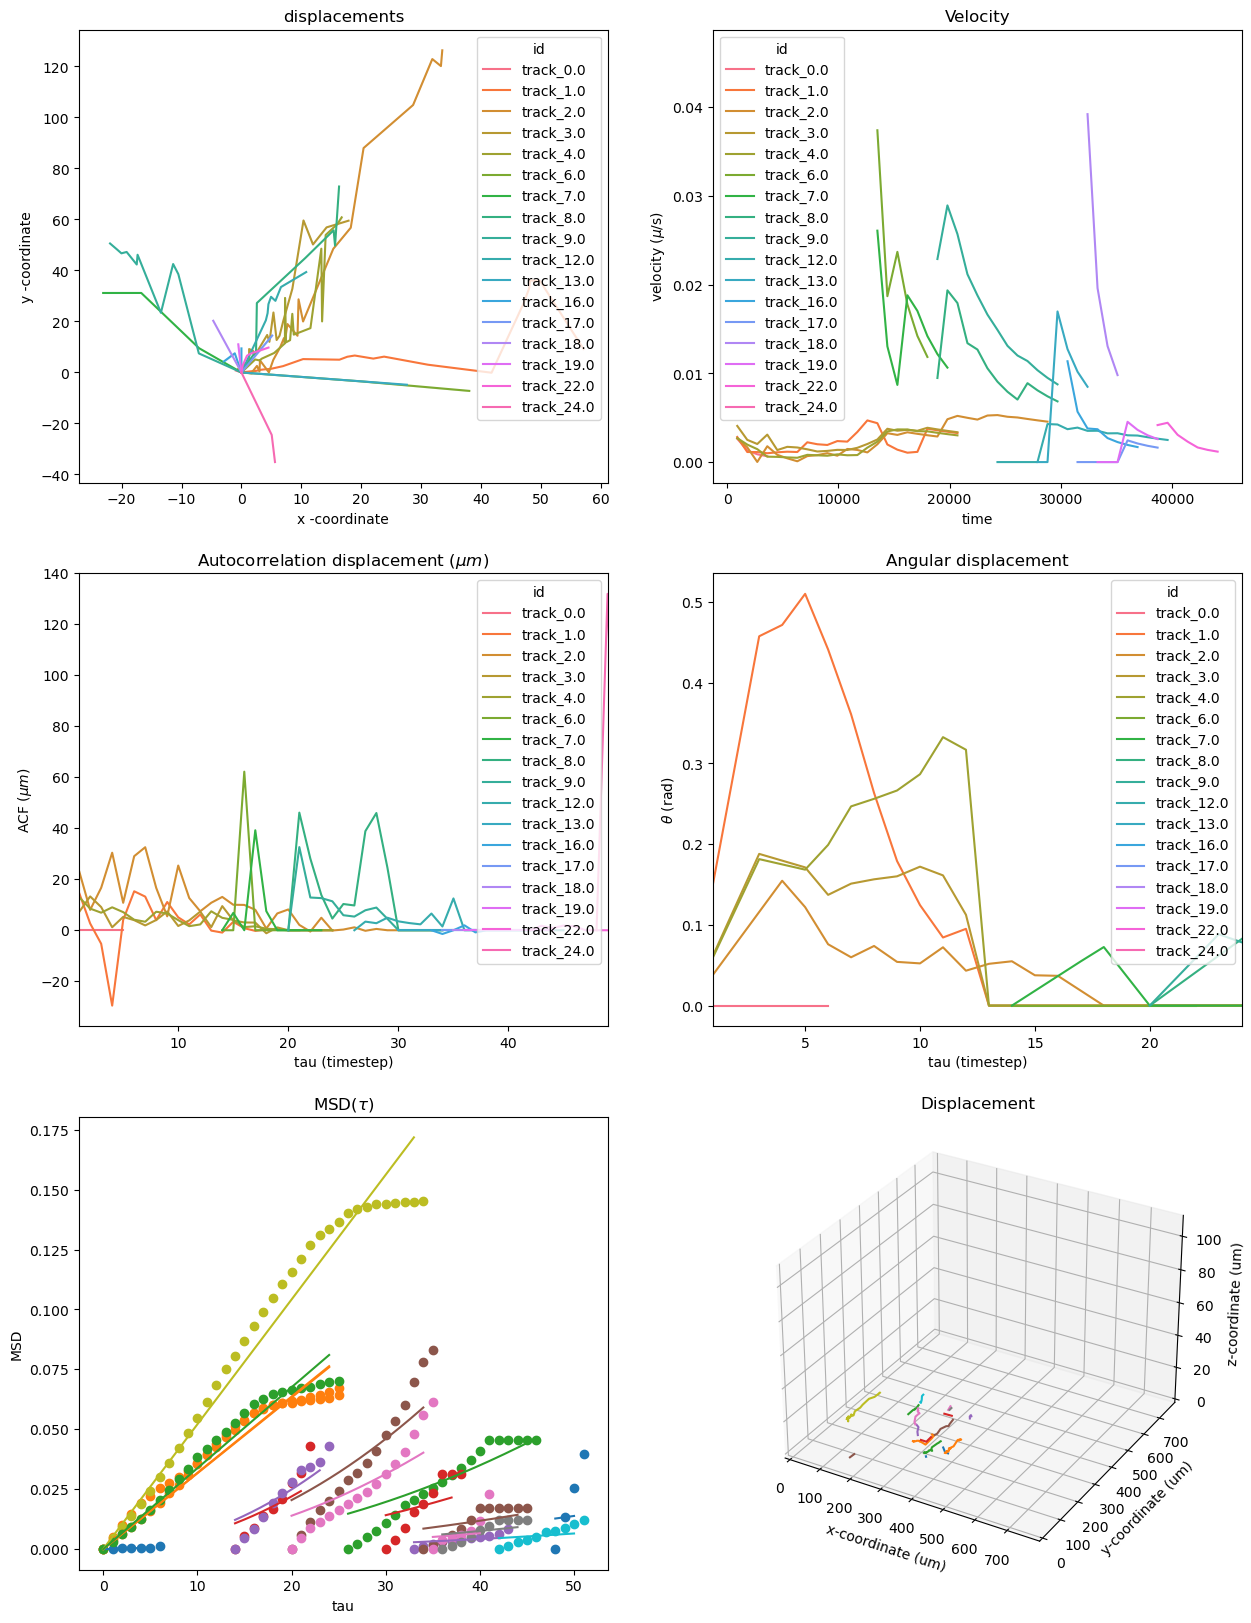

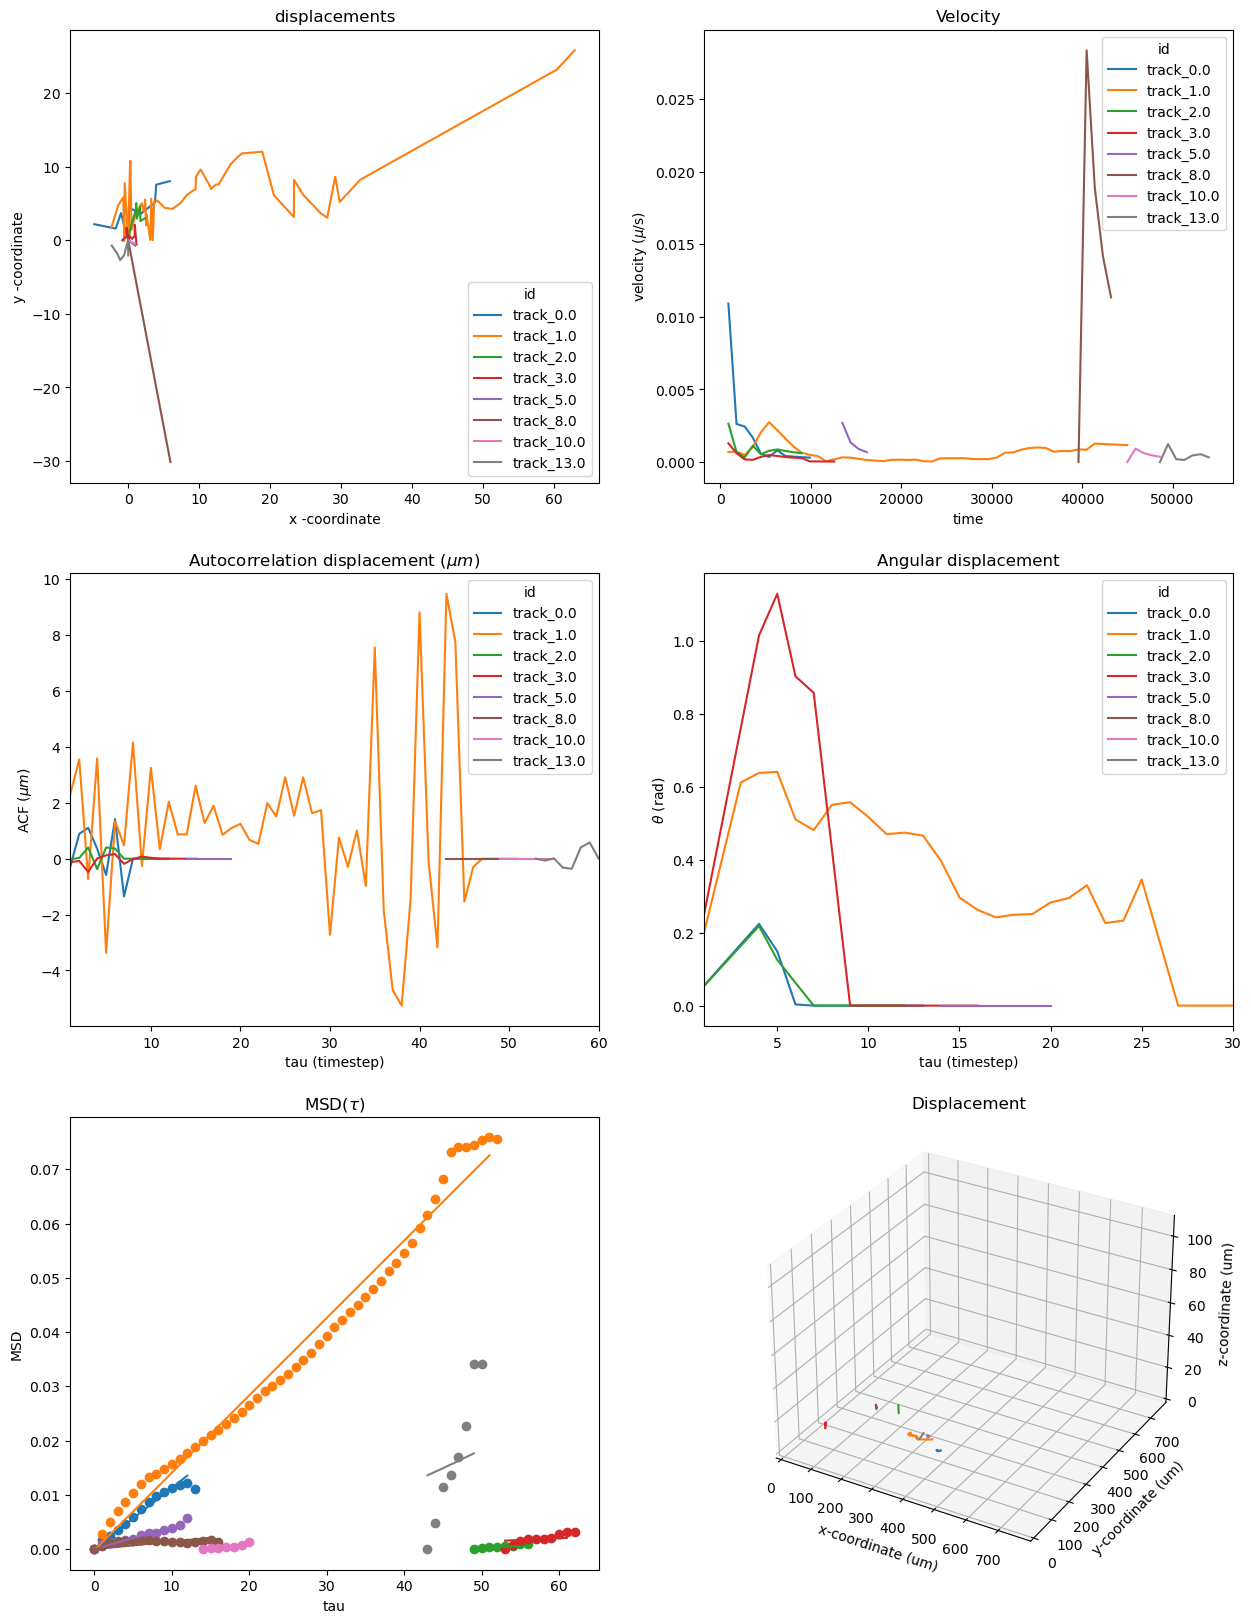

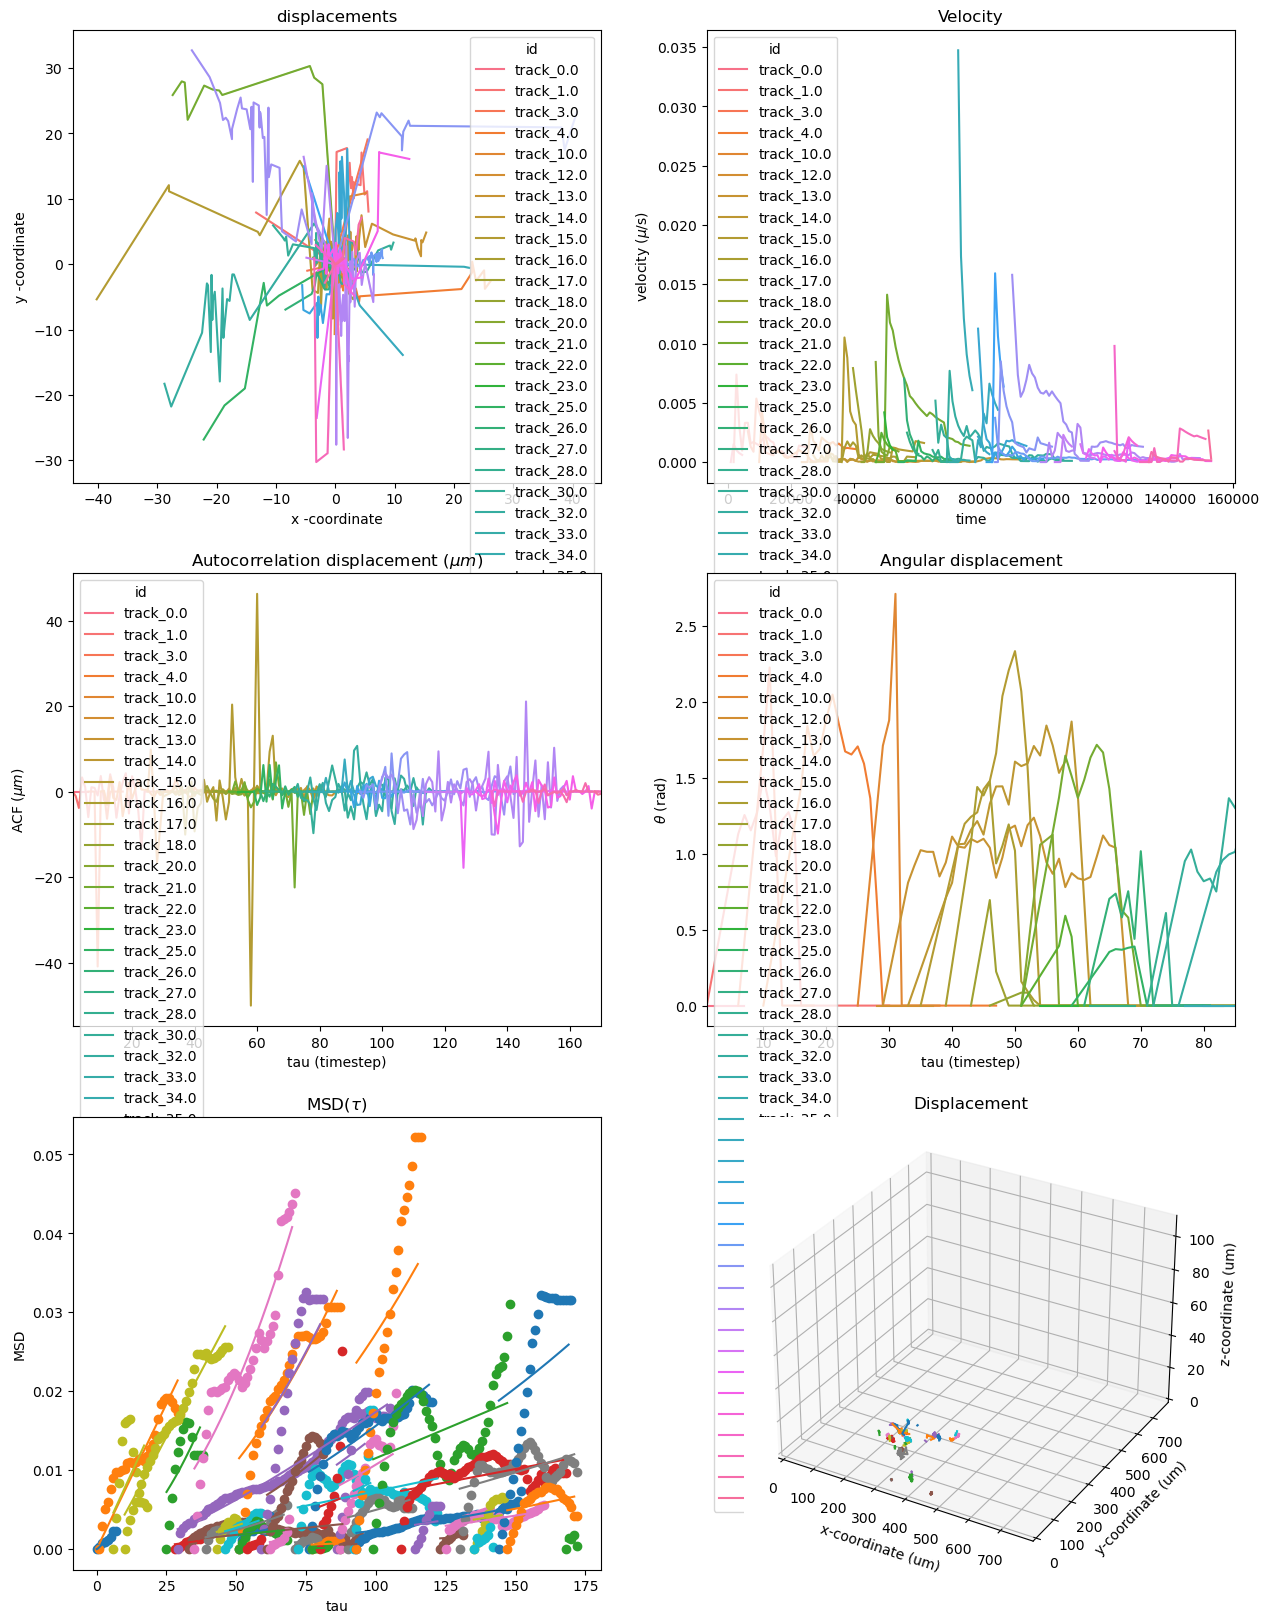

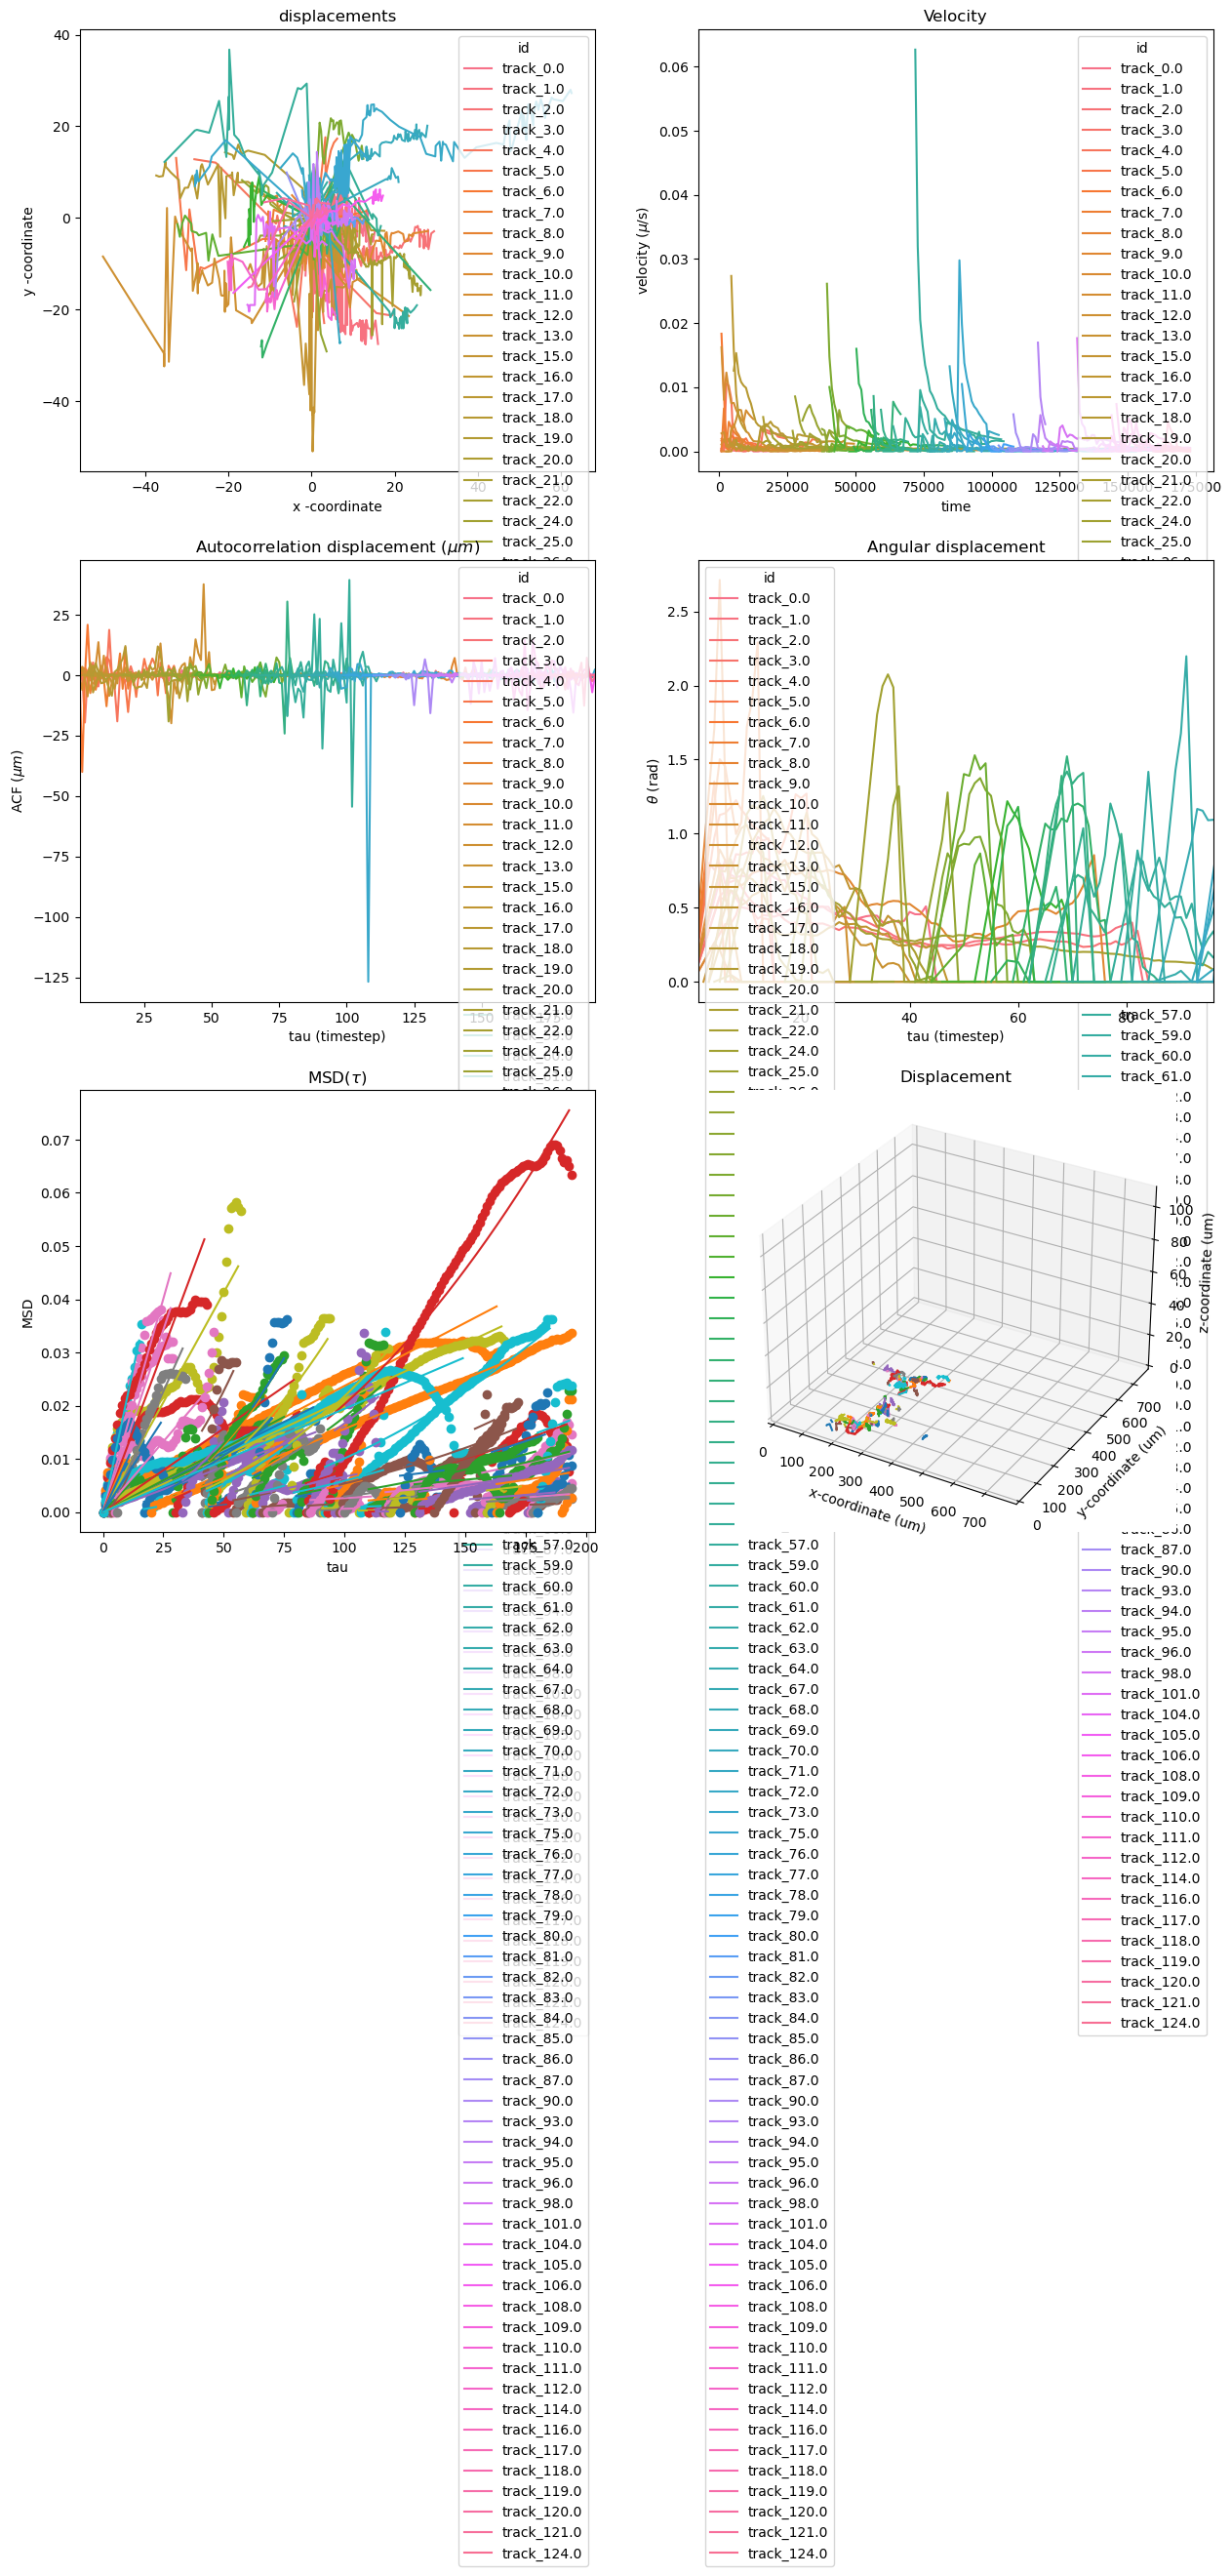

In [43]:
count = 0
for tags, k in df.groupby(["channel", "location"]):
    
    k = k.reset_index()#.loc[1:df.shape[0]-2,:].reset_index(
    last_time = k["idx"].values[-3]

    fig = plt.figure(figsize=(15,20))
    ax = [ 
        fig.add_subplot(321),
        fig.add_subplot(322),
        fig.add_subplot(323),
        fig.add_subplot(324),
        fig.add_subplot(325),
        fig.add_subplot(326, projection='3d')
    ]

    sns.lineplot(x = "x_norm", y = "y_norm", data = k, hue = "id", ax = ax[0])
    ax[0].set_title("displacements")
    ax[0].set_xlabel("x -coordinate")
    ax[0].set_ylabel("y -coordinate")

    sns.lineplot(x = "time", y = "velocity_tau", data = k, hue = "id", ax = ax[1])
    ax[1].set_title("Velocity")
    ax[1].set_xlabel("time")
    ax[1].set_ylabel(r"velocity ($\mu$/s)")

    sns.lineplot(x = "idx", y = "ACF_tau", data = k, hue = "id", ax = ax[2])
    ax[2].set_title(r"Autocorrelation displacement ($\mu m$)")
    ax[2].set_xlabel("tau (timestep)")
    ax[2].set_ylabel(r"ACF ($\mu m$)")
    ax[2].set_xlim([1,last_time])

    sns.lineplot(x = "idx", y = "theta_tau", data = k, hue = "id", ax = ax[3])
    ax[3].set_title("Angular displacement")
    ax[3].set_xlabel("tau (timestep)")
    ax[3].set_ylabel(r"$\theta$ (rad)")
    ax[3].set_xlim([1,int(last_time/2)])

    for count, i in (k.groupby(["id"])):
        ax[4].scatter(i["idx"], i["MSD_tau"], label = "track_{}".format(count))
        popt, pcov, tau_pred, MSD_pred, diffusion_coef = MSD_2D(i["MSD_tau"].values[:-1], i["idx"].values[:-1])
        ax[4].plot(tau_pred, MSD_pred, label = "Fit")

    #ax[2,0].legend()
    ax[4].set_title(r"MSD($\tau$)")
    ax[4].set_xlabel("tau")
    ax[4].set_ylabel("MSD")
    #print("2D MSD" *popt, " Diff: ",  diffusion_coef)

    ax[5].set_title(r"Displacement")
    for count, i in (k.groupby(["id"])):
        ax[5].plot(i["x"],i["y"],i["z"]*10, label =  "track_{}".format(count))


    pixel_conv = 0.34
    coord_lim = 2304*pixel_conv

    ax[5].set_xlim([0,coord_lim])
    ax[5].set_ylim([0,coord_lim])
    ax[5].set_zlim([0,n_levels])

    ax[5].set_xlabel("x-coordinate (um)")
    ax[5].set_ylabel("y-coordinate (um)")
    ax[5].set_zlabel("z-coordinate (um)")
    print("saved: ", os.path.join("./results", "sim_{}_{}_{}.png".format(day, tags[0], tags[1])))

    fig.savefig(os.path.join("./results", "sim_{}_{}_{}.png".format(day, tags[0], tags[1])))


## Optical Flow

,index,x,y,z,idx,id,x_norm,y_norm,z_norm,location,channel,dt,time,velocity_2D,velocity_3D,MSD,ACF_tau,theta_tau,MSD_tau,velocity_tau
0,3009024,109168.484375,516848.5000,552.959961,308736.0,track_16.0track_16.0track_16.0track_16.0track_...,0.000000,0.000000,0.000000,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,277862400.0,0.000000,0.000000,0.523869,0.000000,0.000000,0.000000,NaN
1,3011328,109168.484375,516848.5000,552.959961,311040.0,track_16.0track_16.0track_16.0track_16.0track_...,0.000000,0.000000,0.000000,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,279936000.0,0.000000,0.000000,0.523869,-72.935524,NaN,0.523869,0.000000
2,3013632,109168.484375,516848.5000,552.959961,313344.0,track_16.0track_16.0track_16.0track_16.0track_...,0.000000,0.000000,0.000000,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,282009600.0,1.154986,1.159516,0.523869,-33.844477,NaN,0.883108,0.000000
3,3015936,111185.390625,517352.6875,737.273987,315648.0,track_16.0track_16.0track_16.0track_16.0track_...,2016.905273,504.210938,184.314026,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,284083200.0,1.154986,1.159516,0.523869,107.146912,288.141617,1.095121,0.792323
4,3018240,111185.390625,517352.6875,737.273987,317952.0,track_16.0track_16.0track_16.0track_16.0track_...,2016.905273,504.210938,184.314026,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,286156800.0,0.850583,0.856704,0.523869,-15.093599,441.605072,1.370144,0.594242
5,3020544,111437.156250,515842.5000,553.266174,320256.0,track_16.0track_16.0track_16.0track_16.0track_...,2268.667969,-1005.996094,0.306175,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,288230400.0,0.313848,0.330130,0.523869,61.812324,587.490570,1.693496,1.029128
6,3022848,111688.859375,517096.4375,552.960999,322560.0,track_16.0track_16.0track_16.0track_16.0track_...,2520.369141,247.957031,0.001030,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,290304000.0,0.633078,0.633078,0.523869,0.000000,679.324035,2.006469,0.595125
7,3025152,111564.054688,516974.9375,552.959961,324864.0,track_16.0track_16.0track_16.0track_16.0track_...,2395.564453,126.457031,0.000000,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,292377600.0,0.598896,0.598896,0.523869,0.000000,0.000000,2.231575,0.509365
8,3027456,112317.492188,516220.6875,552.959961,327168.0,track_16.0track_16.0track_16.0track_16.0track_...,3149.006836,-627.785156,0.000000,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,294451200.0,0.592275,0.592275,0.523869,0.000000,0.000000,2.554257,0.741832
9,3029760,112317.492188,516220.6875,552.959961,329472.0,track_16.0track_16.0track_16.0track_16.0track_...,3149.006836,-627.785156,0.000000,9999999999999999999999999999999999999999999999...,RedRedRedRedRedRedRedRedRedRedRedRedRedRedRedR...,2073600,296524800.0,0.000000,0.000000,0.523869,0.000000,0.000000,2.852187,0.659406


In [ ]:
drive = ['D:/instru_projects/timelapses/']
paths = ['231029']

for path_,drive_ in zip(paths,drive):
    
    path = f'{drive_}{path_}'
    print(path)
    vid_name = max( glob(os.path.join(path,'*.nd2')),
                key =  lambda x: os.stat(x).st_size)
    
    with ND2Reader(vid_name) as images:
        print(images.metadata.keys())

In [5]:
def optical_flow(frame, prev):
    #frameGray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev,frame, None, 0.5, 10, 5, 3, 5, 1.5, 0)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])

    return frame, mag, ang

drive = ['D:/instru_projects/timelapses/']
paths = ['231029']

#drive_e = ['']
vis = True
save = True



ball = skimage.morphology.disk(5)
conv_coef = 70

DBScan_distance = 5
DBScan_minSample = 2
num = 25


if vis:
    cv2.namedWindow('vis', cv2.WINDOW_AUTOSIZE)

for path_,drive_ in zip(paths,drive):
    
    path = f'{drive_}{path_}'
    vid_name = max( glob(os.path.join(path,'*.nd2')),
                key =  lambda x: os.stat(x).st_size)
    
    #Read metadata
    with ND2Reader(vid_name) as images:
        
        n_fields = images.metadata['fields_of_view'].stop
        m = images.metadata['pixel_microns']
        n_frames = images.metadata['num_frames']
        z_level = (np.max(images.metadata['z_coordinates'])-np.min(images.metadata['z_coordinates']))
        n_levels = images.metadata['z_levels'].stop
        z_step = z_level/n_levels
        channels = images.metadata['channels']
        n_channels = len(channels)
        vis_level = int(n_levels/2)
        metas = images.metadata
        width = images.metadata["width"]
        height = images.metadata["height"]
        dim = (width, height)
        num_bf = [metas["channels"].index(i) for i in ["BF"]][0]

    
    """
    counts = {}

    #Skip bf
    for i in channels:
        if i == "BF":
            continue
        else:
            counts[i] = {}
            counts[i]['angles'] = {}
            counts[i]['mags'] = {}
            counts[i]['frames'] = {}

            for j in range(n_fields):
                counts[i]['angles'][j] = []
                counts[i]['mags'][j] = []
                counts[i]['frames'][j] = []
    """

    counts = {}
    counts['angles'] = []
    counts['mags'] = []
    counts['frames'] = []

    skip = False

    t_id = 0
    v_id = 0
    FoV_counter = 0
    channel_flags = np.zeros(len(channels))

    with ND2Reader(vid_name) as images:

        #images.iter_axes = 'tc' # one location
        images.iter_axes = 'vtc' # multiple locations
        images.bundle_axes = 'zyx'

        for idx,img in tqdm(enumerate(images),total=int(n_channels*n_fields*n_frames)):

            c_id = idx%n_channels
            id_name = channels[c_id]

            if (save) & (FoV_counter == 0):
                out_process = ( 
                ffmpeg 
                .input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
                .format(1050,720)) 
                .filter('fps', fps=5, round='up')
                .output("{}_optical_flow_{}.mp4".format(files[0][:-16], v_id), pix_fmt='yuv420p') .overwrite_output() 
                .run_async(pipe_stdin=True) 
            )

            # skip brightfield
            if (id_name == "BF"):
                if idx != 0:
                    t_id += 1

                continue
            
            stack_mag = np.zeros((n_levels,width,height))
            stack_angle = np.zeros((n_levels,width,height))
            stack_img = np.zeros((n_levels,width,height))

            for i in images.metadata['z_levels']:
                if channel_flags[c_id] == 0:
                    prev = np.zeros(dim)
                else:
                    #print("fetching from memory")
                    prev = counts['mags'][-1][i]
                          
                final = cv2.normalize(img[i,...], None, 0, 255, cv2.NORM_MINMAX).astype("uint8")
                final = skimage.filters.rank.median(final, ball) #img[i,...]
                frameGray, mag, ang = optical_flow(final, prev)
                
                stack_mag[i] = mag
                stack_angle[i] = ang
                stack_img[i] = frameGray
                #print("stack", i,"/")
            
            if (vis == True) | (save == True):
                #print("Display")
                e_frame_idx = int(i/2)
                vis_frame = stack_img[e_frame_idx].astype("uint8")

                u = stack_angle[e_frame_idx]*180/np.pi/2
                v = cv2.normalize(stack_mag[e_frame_idx],None,0,255,cv2.NORM_MINMAX)

                grey_3_channel = cv2.cvtColor(vis_frame, cv2.COLOR_GRAY2BGR)

                hsv = np.zeros_like(grey_3_channel)
                hsv[...,1] = 255
                hsv[...,0] = u
                hsv[...,2] = v
                rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

                fig, ax = plt.subplots(1,2, figsize=(15,10))
                
                #h_stack = np.hstack((frame_new, rgb))
                ax[0].imshow(np.stack((vis_frame,vis_frame,vis_frame), axis = -1))
                h = ax[1].imshow(rgb, interpolation="bilinear", cmap='viridis')
                cbar = fig.colorbar(h, label = "optical Flow [Amp]")

                ax[0].axis('off')
                ax[1].axis('off')
                
                ax[0].set_title('Timelapse')
                ax[1].set_title('Optical flow: magnitude and flow')

                h, w, *_ = vis_frame.shape

                u_ = stack_mag[e_frame_idx]*np.sin(stack_angle[e_frame_idx]).reshape(h, w)
                v_ = stack_mag[e_frame_idx]*np.cos(stack_angle[e_frame_idx]).reshape(h, w)

                #u = u.reshape(h, w); v = v.reshape(h, w) 
                x = np.arange(0,w)
                y = np.arange(0,h)
                xx, yy = np.meshgrid(x ,y)
                #yy = yy.max()-yy
                #kwargs = {**dict(angles="xy", scale_units="xy"), **kwargs} , **kwargs
                ax[1].quiver(xx[::num, ::num], yy[::num, ::num], u_[::num, ::num], v_[::num, ::num], color = "white", headwidth=7, scale = 75, headlength=5) #xx[::num, ::num], yy[::num, ::num], 

                fig.canvas.draw()
                # convert canvas to image
                img_proc = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,
                        sep='')
                img_proc  = img_proc.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                img_new = cv2.resize(img_proc, (1050,720))
                plt.close()

            if vis:
                cv2.imshow("vis", img_new)
                k = cv2.waitKey(1)

            if save:
                out_process.stdin.write(img_new)

            if channel_flags[c_id] == 0:
                channel_flags[c_id] = 1

            counts['mags'].append(stack_mag)
            counts['angles'].append(stack_angle)
            counts['frames'].append(stack_img)

            if (FoV_counter == ((n_frames-1))) & (idx != 0) :
                print("Switched Field of view")
                print("Field of view", v_id ,"/", n_fields-1, "\nChannel", id_name, "\nTimestamp", t_id%n_frames , "/", n_frames-1, "\nFoV_counter", FoV_counter, "\n--------------\n", end='\r')

                with open(f'./results/{paths}_{v_id}.pickle', 'wb') as handle:
                    pickle.dump(counts, handle, protocol=pickle.HIGHEST_PROTOCOL)

                counts = {}
                counts['angles'] = []
                counts['mags'] = []
                counts['frames'] = []
                
                out_process.stdin.close()
                out_process.wait()

                channel_flags = np.zeros(len(channels))
                v_id += 1
                FoV_counter = 0
            else:
                if FoV_counter in [0,25,50,75,100]:
                    print("Field of view", v_id ,"/", n_fields-1, "\nChannel", id_name, "\nTimestamp", t_id%n_frames , "/", n_frames-1, "\nFoV_counter", FoV_counter, "\n--------------\n", end='\r')
                FoV_counter += 1

if vis:
    cv2.destroyAllWindows()

if save:
    out_process.stdin.close()
    out_process.wait()


"""
            if vis:


                if vis:
                    cv2.imshow('vis',out)
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                        break

            #id_name = channels[c_id]
            if (t_id != 0) and ((t_id%n_frames)==0):
                if not skip:
                    skip = True
                    v_id += 1
            else:
                skip = False

            

    pp = path_.replace('/','_')
    if save:
        with open(f'./results/{pp}.pickle', 'wb') as handle:
            pickle.dump(counts, handle, protocol=pickle.HIGHEST_PROTOCOL)
if vis:
    cv2.destroyAllWindows()
"""

  0%|          | 0/4896 [00:00<?, ?it/s]C:\Users\lehtona6\AppData\Local\Temp\ipykernel_12932\3972074191.py:176: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img_proc = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,
  0%|          | 2/4896 [00:04<2:35:37,  1.91s/it]

Field of view 0 / 17 
Channel Red 
Timestamp 0 / 135 
FoV_counter 0 
--------------


  1%|          | 52/4896 [02:06<2:39:14,  1.97s/it]

Field of view 0 / 17 
Channel Red 
Timestamp 25 / 135 
FoV_counter 25 
--------------


  2%|▏         | 102/4896 [04:07<2:44:30,  2.06s/it]

Field of view 0 / 17 
Channel Red 
Timestamp 50 / 135 
FoV_counter 50 
--------------


  3%|▎         | 152/4896 [06:16<2:58:32,  2.26s/it]

Field of view 0 / 17 
Channel Red 
Timestamp 75 / 135 
FoV_counter 75 
--------------


  4%|▍         | 202/4896 [08:29<2:46:40,  2.13s/it]

Field of view 0 / 17 
Channel Red 
Timestamp 100 / 135 
FoV_counter 100 
--------------


  6%|▌         | 270/4896 [11:35<2:39:30,  2.07s/it]

Switched Field of view
Field of view 0 / 17 
Channel Red 
Timestamp 135 / 135 
FoV_counter 135 
--------------


  6%|▌         | 274/4896 [33:37<176:14:26, 137.27s/it]

Field of view 1 / 17 
Channel Red 
Timestamp 0 / 135 
FoV_counter 0 
--------------


  7%|▋         | 324/4896 [35:32<2:32:48,  2.01s/it]   

Field of view 1 / 17 
Channel Red 
Timestamp 25 / 135 
FoV_counter 25 
--------------


  8%|▊         | 374/4896 [37:37<2:35:08,  2.06s/it]

Field of view 1 / 17 
Channel Red 
Timestamp 50 / 135 
FoV_counter 50 
--------------


  9%|▊         | 424/4896 [39:42<2:22:18,  1.91s/it]

Field of view 1 / 17 
Channel Red 
Timestamp 75 / 135 
FoV_counter 75 
--------------


 10%|▉         | 473/4896 [41:54<3:55:05,  3.19s/it]

Field of view 1 / 17 
Channel Red 
Timestamp 100 / 135 
FoV_counter 100 
--------------


 11%|█         | 542/4896 [46:51<4:35:34,  3.80s/it]

Switched Field of view
Field of view 1 / 17 
Channel Red 
Timestamp 135 / 135 
FoV_counter 135 
--------------


 11%|█         | 545/4896 [1:08:13<231:11:24, 191.29s/it]

Field of view 2 / 17 
Channel Red 
Timestamp 0 / 135 
FoV_counter 0 
--------------


 12%|█▏        | 595/4896 [1:11:57<6:46:17,  5.67s/it]   

Field of view 2 / 17 
Channel Red 
Timestamp 25 / 135 
FoV_counter 25 
--------------


 13%|█▎        | 645/4896 [1:16:12<6:36:20,  5.59s/it] 

Field of view 2 / 17 
Channel Red 
Timestamp 50 / 135 
FoV_counter 50 
--------------


 14%|█▍        | 695/4896 [1:20:23<7:10:25,  6.15s/it]

Field of view 2 / 17 
Channel Red 
Timestamp 75 / 135 
FoV_counter 75 
--------------


 15%|█▌        | 745/4896 [1:24:43<7:01:58,  6.10s/it]

Field of view 2 / 17 
Channel Red 
Timestamp 100 / 135 
FoV_counter 100 
--------------


 17%|█▋        | 814/4896 [1:30:17<4:30:56,  3.98s/it] 

Switched Field of view
Field of view 2 / 17 
Channel Red 
Timestamp 135 / 135 
FoV_counter 135 
--------------


 17%|█▋        | 817/4896 [1:51:44<218:02:45, 192.44s/it]

Field of view 3 / 17 
Channel Red 
Timestamp 0 / 135 
FoV_counter 0 
--------------


 18%|█▊        | 867/4896 [1:55:29<6:07:54,  5.48s/it]   

Field of view 3 / 17 
Channel Red 
Timestamp 25 / 135 
FoV_counter 25 
--------------


 19%|█▊        | 917/4896 [1:59:35<6:43:21,  6.08s/it]

Field of view 3 / 17 
Channel Red 
Timestamp 50 / 135 
FoV_counter 50 
--------------


 20%|█▉        | 967/4896 [2:04:11<7:05:20,  6.50s/it]

Field of view 3 / 17 
Channel Red 
Timestamp 75 / 135 
FoV_counter 75 
--------------


 21%|██        | 1017/4896 [2:08:48<7:11:46,  6.68s/it] 

Field of view 3 / 17 
Channel Red 
Timestamp 100 / 135 
FoV_counter 100 
--------------


 22%|██▏       | 1074/4896 [2:13:48<7:56:12,  7.48s/it]


MemoryError: Unable to allocate 111. MiB for an array with shape (11, 1152, 1152) and data type float64

In [3]:
cv2.destroyAllWindows()

In [ ]:
#stacks = len(counts["Red"]["frames"][0])


dim_2 = (1050,720)

num = 50

out_process = ( 
    ffmpeg 
.input('pipe:', format='rawvideo', pix_fmt='rgb24', s='{}x{}'
.format(1050,720)) 
.filter('fps', fps=5, round='up')
.output("./results/optical_flow.mp4", pix_fmt='yuv420p') .overwrite_output() 
.run_async(pipe_stdin=True) 
)


#cv2.namedWindow('vis', cv2.WINDOW_AUTOSIZE)

for count, i in enumerate(counts["Red"]["frames"][0]):

    fig, ax = plt.subplots(1,2, figsize=(15,10))
    
    frame_new = cv2.cvtColor(i[5].astype("uint8"), cv2.COLOR_GRAY2BGR)
    hsv = np.zeros_like(frame_new)
    hsv[...,1] = 255
    hsv[...,0] = counts["Red"]["angles"][0][count][5]*180/np.pi/2
    hsv[...,2] = cv2.normalize(counts["Red"]["mags"][0][count][5],None,0,255,cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

    #h_stack = np.hstack((frame_new, rgb))
    ax[0].imshow(frame_new)
    ax[1].imshow(rgb)
    h, w, *_ = frame_new.shape 

    u = counts["Red"]["angles"][0][count][5]*180/np.pi/2 #counts["Red"]["mags"][0][count][5].reshape(h, w)
    v = cv2.normalize(counts["Red"]["mags"][0][count][5],None,0,255,cv2.NORM_MINMAX) #-counts["Red"]["angles"][0][count][5].reshape(h, w)
    
    u = u.reshape(h, w); v = v.reshape(h, w) 
    x = np.arange(0,w)
    y = np.arange(0,h)

    xx, yy = np.meshgrid(x ,y)
    #yy = yy.max()-yy

    #kwargs = {**dict(angles="xy", scale_units="xy"), **kwargs} , **kwargs
    ax[1].quiver(xx[::num, ::num], yy[::num, ::num], u[::num, ::num], v[::num, ::num], color = "white")

    fig.canvas.draw()

    # convert canvas to image
    img_proc = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,
            sep='')
    img_proc  = img_proc.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    img_new = cv2.resize(img_proc, (1050,720))
    cv2.imshow("vis", img_new)
    plt.close()
    out_process.stdin.write(img_new)
    k = cv2.waitKey(10)

out_process.stdin.close()
out_process.wait()

cv2.destroyAllWindows()

In [ ]:
count = 5
num = 25
i = counts["Red"]["frames"][0][count]

fig, ax = plt.subplots(1,2, figsize=(15,15))

frame_new = cv2.cvtColor(i[5].astype("uint8"), cv2.COLOR_GRAY2BGR)
hsv = np.zeros_like(frame_new)
hsv[...,1] = 255
hsv[...,0] = counts["Red"]["angles"][0][count][5]*180/np.pi/2
hsv[...,2] = cv2.normalize(counts["Red"]["mags"][0][count][5],None,0,255,cv2.NORM_MINMAX)
rgb = cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

#h_stack = np.hstack((frame_new, rgb))
ax[0].imshow(frame_new)
ax[1].imshow(rgb, cmap='jet', interpolation='nearest')


h, w, *_ = frame_new.shape 

ang = counts["Red"]["angles"][0][count][5] #counts["Red"]["mags"][0][count][5].reshape(h, w)
mag = counts["Red"]["mags"][0][count][5] #counts["Red"]["angles"][0][count][5].reshape(h, w)

u_ = mag*np.sin(ang).reshape(h, w)
v_ = mag*np.cos(ang).reshape(h, w)

x = np.arange(0,w)
y = np.arange(0,h)

xx, yy = np.meshgrid(x ,y)
#yy = yy.max()-yy

#kwargs = {**dict(angles="xy", scale_units="xy"), **kwargs} , **kwargs
ax[1].quiver(xx[::num, ::num], yy[::num, ::num],u_[::num, ::num], v_[::num, ::num], color = "white", headwidth=7, scale = 75, headlength=5)

plt.show()
"""
ax[0].axis("off")

fig.canvas.draw()

# convert canvas to image
img_proc = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8,
        sep='')
img_proc  = img_proc.reshape(fig.canvas.get_width_height()[::-1] + (3,))

img_new = cv2.resize(img_proc, (1050,720))
cv2.imshow("vis", img_new)
plt.close()
#out_process.stdin.write(img_new)
k = cv2.waitKey(10)
"""